In [2]:
# Standard library imports
import sys
from pathlib import Path
from typing import Tuple, Optional

# Third-party imports
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import hilbert

# Add src to path for local imports
src_path = Path.cwd().parent.parent.parent / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

# Local imports
from signals import generate_sine_wave
from spectral import compute_psd_welch
from filtering import bandpass_filter, lowpass_filter
from colors import COLORS
from constants import EEG_BANDS, BAND_COLORS

# Define color constants
PRIMARY_BLUE = COLORS["signal_1"]
SECONDARY_PINK = COLORS["signal_2"]
PRIMARY_GREEN = COLORS["signal_3"]
ACCENT_GOLD = COLORS["signal_4"]
ACCENT_PURPLE = COLORS["signal_5"]
ACCENT_TEAL = COLORS["signal_6"]
PRIMARY_RED = COLORS["negative"]
PLOT_BG_COLOR = COLORS["background"]

# Matplotlib configuration
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 11

print(f"NumPy version: {np.__version__}")
print(f"Source path: {src_path}")

NumPy version: 2.3.5
Source path: /Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials/src


---

## 1. Introduction

Many connectivity metrics in hyperscanning research require **phase** or **amplitude** information:

- **Phase-based metrics** (PLV, PLI, wPLI): Measure synchronization by comparing phases between signals
- **Amplitude-based metrics** (Envelope Correlation, Power Correlation): Track co-fluctuations in signal strength

But there's a fundamental problem: **a raw signal doesn't have a single "phase."** A real EEG signal is a mixture of many frequencies, each with its own phase. Which phase do we report?

The solution involves two steps:
1. **Band-pass filter** the signal to isolate a narrow frequency range (e.g., alpha 8-13 Hz)
2. Apply the **Hilbert transform** to extract instantaneous amplitude and phase

The Hilbert transform is the mathematical tool that enables this extraction. It's the foundation for virtually all phase-based and many amplitude-based connectivity analyses in neuroscience.

---

## 2. The Problem — What is "Phase" of a Complex Signal?

For a **pure sine wave**, phase is well-defined at every time point:

$$x(t) = A \sin(2\pi f t + \phi)$$

At any time $t$, the phase is simply $2\pi f t + \phi$.

But for a **composite signal** (sum of multiple frequencies), there is no single phase. Which frequency's phase do we report?

Let's visualize this problem:

/var/folders/tw/x1b5ldls1_s1t0h65sy4nsym0000gp/T/ipykernel_30407/2577898372.py:69: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10067 (\N{BLACK QUESTION MARK ORNAMENT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


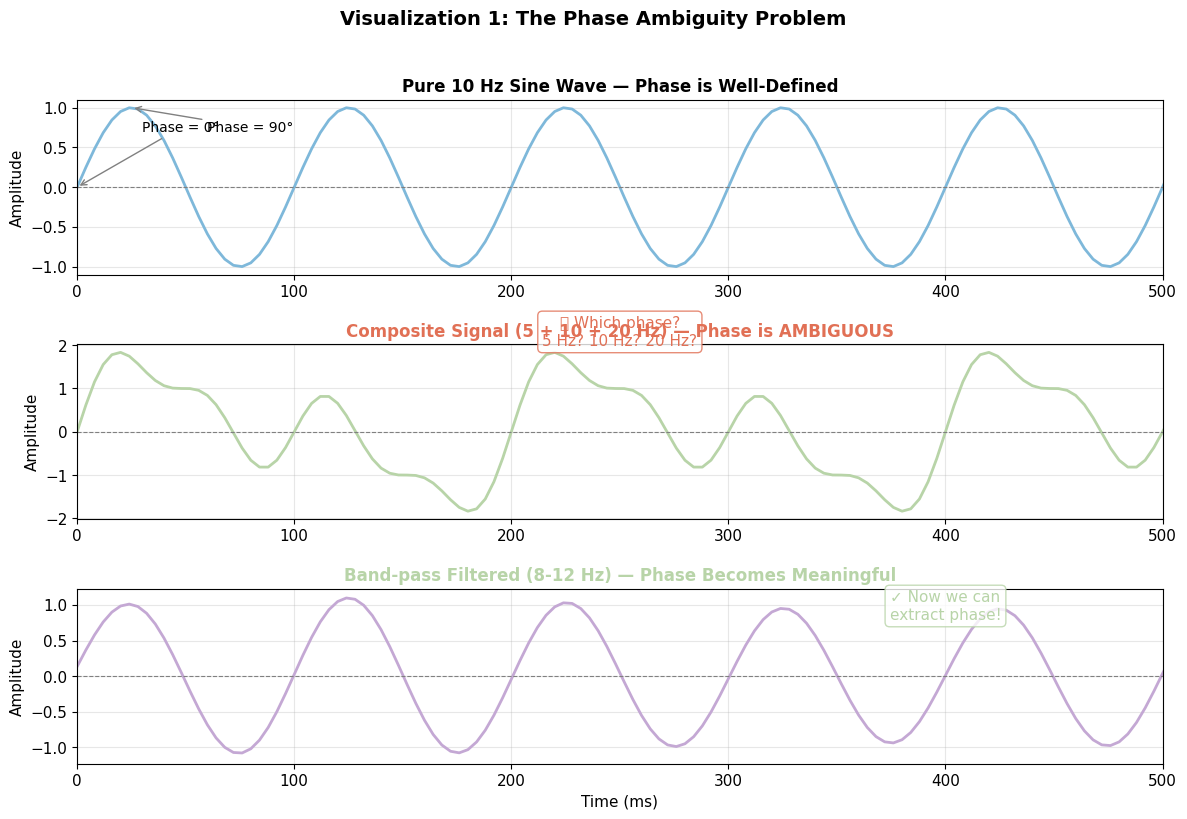

Key insight: We must filter to a narrow band before extracting phase.
But HOW do we extract phase from the filtered signal? → Hilbert Transform!


In [3]:
# ============================================================================
# VISUALIZATION 1: Phase Ambiguity in Composite Signals
# ============================================================================

# Parameters
fs = 250  # Sampling rate
duration = 1.0  # seconds
t = np.arange(0, duration, 1/fs)

# Create signals
pure_10hz = np.sin(2 * np.pi * 10 * t)
composite = (np.sin(2 * np.pi * 5 * t) + 
             np.sin(2 * np.pi * 10 * t) + 
             0.5 * np.sin(2 * np.pi * 20 * t))

# Band-pass filter to isolate 10 Hz
filtered_10hz = bandpass_filter(composite, 8, 12, fs)

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Plot 1: Pure sine wave
ax1 = axes[0]
ax1.plot(t * 1000, pure_10hz, color=PRIMARY_BLUE, linewidth=2)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Pure 10 Hz Sine Wave — Phase is Well-Defined', fontsize=12, fontweight='bold')
ax1.set_xlim(0, 500)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

# Add phase annotation
ax1.annotate('Phase = 0°', xy=(0, 0), xytext=(30, 0.7),
             fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))
ax1.annotate('Phase = 90°', xy=(25, 1), xytext=(60, 0.7),
             fontsize=10, arrowprops=dict(arrowstyle='->', color='gray'))

# Plot 2: Composite signal
ax2 = axes[1]
ax2.plot(t * 1000, composite, color=PRIMARY_GREEN, linewidth=2)
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Composite Signal (5 + 10 + 20 Hz) — Phase is AMBIGUOUS', 
              fontsize=12, fontweight='bold', color=PRIMARY_RED)
ax2.set_xlim(0, 500)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

# Add warning annotation
ax2.text(250, 2, '❓ Which phase?\n5 Hz? 10 Hz? 20 Hz?', 
         ha='center', fontsize=11, color=PRIMARY_RED,
         bbox=dict(boxstyle='round', facecolor='white', edgecolor=PRIMARY_RED, alpha=0.8))

# Plot 3: Filtered signal
ax3 = axes[2]
ax3.plot(t * 1000, filtered_10hz, color=ACCENT_PURPLE, linewidth=2)
ax3.set_xlabel('Time (ms)', fontsize=11)
ax3.set_ylabel('Amplitude', fontsize=11)
ax3.set_title('Band-pass Filtered (8-12 Hz) — Phase Becomes Meaningful', 
              fontsize=12, fontweight='bold', color=PRIMARY_GREEN)
ax3.set_xlim(0, 500)
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

# Add success annotation
ax3.text(400, 0.8, '✓ Now we can\nextract phase!', 
         ha='center', fontsize=11, color=PRIMARY_GREEN,
         bbox=dict(boxstyle='round', facecolor='white', edgecolor=PRIMARY_GREEN, alpha=0.8))

plt.suptitle('Visualization 1: The Phase Ambiguity Problem', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Key insight: We must filter to a narrow band before extracting phase.")
print("But HOW do we extract phase from the filtered signal? → Hilbert Transform!")

---

## 3. The Analytic Signal Concept

The key to extracting phase and amplitude is the **analytic signal**.

### Definition

For a real signal $x(t)$, the analytic signal $z(t)$ is:

$$z(t) = x(t) + i \cdot \hat{x}(t)$$

where:
- $x(t)$ is the original real signal
- $\hat{x}(t) = \mathcal{H}\{x(t)\}$ is the **Hilbert transform** of $x(t)$
- $i = \sqrt{-1}$

### What We Can Extract

From the analytic signal, we can compute:

| Quantity | Formula | Meaning |
|----------|---------|--------|
| **Instantaneous Amplitude** | $A(t) = |z(t)| = \sqrt{x^2 + \hat{x}^2}$ | The envelope (signal strength) |
| **Instantaneous Phase** | $\phi(t) = \arg(z(t)) = \text{atan2}(\hat{x}, x)$ | The oscillation phase |

### Geometric Interpretation: The Rotating Phasor

Think of the analytic signal as a **rotating vector** in the complex plane:
- The **real part** (x-axis) is the original signal
- The **imaginary part** (y-axis) is the Hilbert transform
- The **length** of the vector is the amplitude
- The **angle** of the vector is the phase

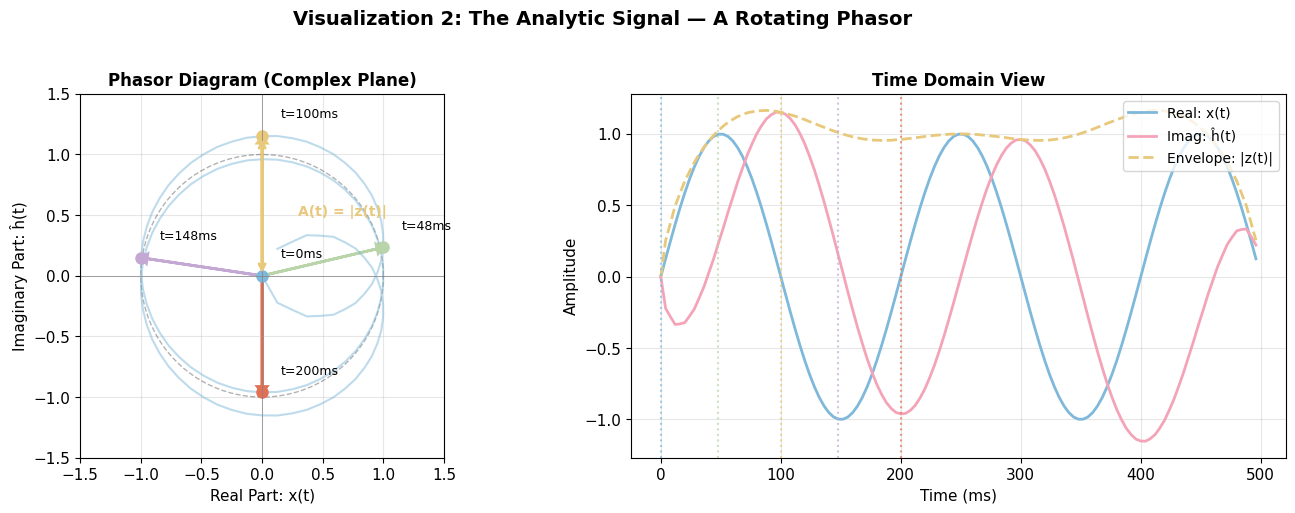

The phasor rotates counterclockwise at the signal frequency.
Its length = amplitude, its angle = phase.


In [4]:
# ============================================================================
# VISUALIZATION 2: The Analytic Signal as a Rotating Phasor
# ============================================================================

# Create a simple sine wave
fs = 250
duration = 0.5
t = np.arange(0, duration, 1/fs)
freq = 5  # Hz
signal_sin = np.sin(2 * np.pi * freq * t)

# Compute analytic signal
analytic = hilbert(signal_sin)
real_part = np.real(analytic)
imag_part = np.imag(analytic)
envelope = np.abs(analytic)
phase = np.angle(analytic)

# Create figure with phasor diagram and time series
fig = plt.figure(figsize=(14, 5))

# Left: Phasor diagram (complex plane)
ax1 = fig.add_subplot(1, 2, 1)

# Draw the unit circle
theta_circle = np.linspace(0, 2*np.pi, 100)
ax1.plot(np.cos(theta_circle), np.sin(theta_circle), 'k--', alpha=0.3, linewidth=1)

# Plot the trajectory of the analytic signal
ax1.plot(real_part, imag_part, color=PRIMARY_BLUE, linewidth=1.5, alpha=0.5, label='Trajectory')

# Show a few phasor snapshots
snapshot_indices = [0, 12, 25, 37, 50]
colors_snap = [PRIMARY_BLUE, PRIMARY_GREEN, ACCENT_GOLD, ACCENT_PURPLE, PRIMARY_RED]

for idx, color in zip(snapshot_indices, colors_snap):
    ax1.arrow(0, 0, real_part[idx]*0.95, imag_part[idx]*0.95, 
              head_width=0.08, head_length=0.05, fc=color, ec=color, linewidth=2)
    ax1.plot(real_part[idx], imag_part[idx], 'o', color=color, markersize=8)
    ax1.annotate(f't={t[idx]*1000:.0f}ms', xy=(real_part[idx], imag_part[idx]),
                 xytext=(real_part[idx]+0.15, imag_part[idx]+0.15), fontsize=9)

ax1.set_xlim(-1.5, 1.5)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlabel('Real Part: x(t)', fontsize=11)
ax1.set_ylabel('Imaginary Part: ĥ(t)', fontsize=11)
ax1.set_title('Phasor Diagram (Complex Plane)', fontsize=12, fontweight='bold')
ax1.set_aspect('equal')
ax1.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax1.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
ax1.grid(True, alpha=0.3)

# Add labels for amplitude and phase
idx_demo = 25
ax1.annotate('', xy=(real_part[idx_demo], imag_part[idx_demo]), xytext=(0, 0),
             arrowprops=dict(arrowstyle='<->', color=ACCENT_GOLD, lw=2))
ax1.text(0.3, 0.5, 'A(t) = |z(t)|', fontsize=10, color=ACCENT_GOLD, fontweight='bold')

# Right: Time series showing relationship
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(t * 1000, real_part, color=PRIMARY_BLUE, linewidth=2, label='Real: x(t)')
ax2.plot(t * 1000, imag_part, color=SECONDARY_PINK, linewidth=2, label='Imag: ĥ(t)')
ax2.plot(t * 1000, envelope, color=ACCENT_GOLD, linewidth=2, linestyle='--', label='Envelope: |z(t)|')

# Mark snapshot times
for idx, color in zip(snapshot_indices, colors_snap):
    ax2.axvline(x=t[idx]*1000, color=color, linestyle=':', alpha=0.7)

ax2.set_xlabel('Time (ms)', fontsize=11)
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Time Domain View', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.suptitle('Visualization 2: The Analytic Signal — A Rotating Phasor', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("The phasor rotates counterclockwise at the signal frequency.")
print("Its length = amplitude, its angle = phase.")

---

## 4. The Hilbert Transform — Mathematical Definition

### What is the Hilbert Transform?

The Hilbert transform $\mathcal{H}\{x(t)\}$ is a linear operator that **shifts each frequency component by 90°** (π/2 radians):

$$\hat{x}(t) = \mathcal{H}\{x(t)\} = \frac{1}{\pi} \text{P.V.} \int_{-\infty}^{\infty} \frac{x(\tau)}{t - \tau} d\tau$$

where P.V. denotes the Cauchy principal value.

### Frequency Domain Interpretation

In the frequency domain, the Hilbert transform is much simpler:

$$\mathcal{H}\{x\}(\omega) = -i \cdot \text{sgn}(\omega) \cdot X(\omega)$$

This means:
- **Positive frequencies**: multiply by $-i$ → phase shift of $-90°$
- **Negative frequencies**: multiply by $+i$ → phase shift of $+90°$
- **DC component (ω = 0)**: unchanged

### Why 90° Phase Shift?

For a sine wave, a 90° phase shift gives the cosine:

$$x(t) = \sin(2\pi f t) \quad \rightarrow \quad \hat{x}(t) = -\cos(2\pi f t)$$

This creates an **orthogonal companion** to the original signal, which is exactly what we need to form a phasor in the complex plane!

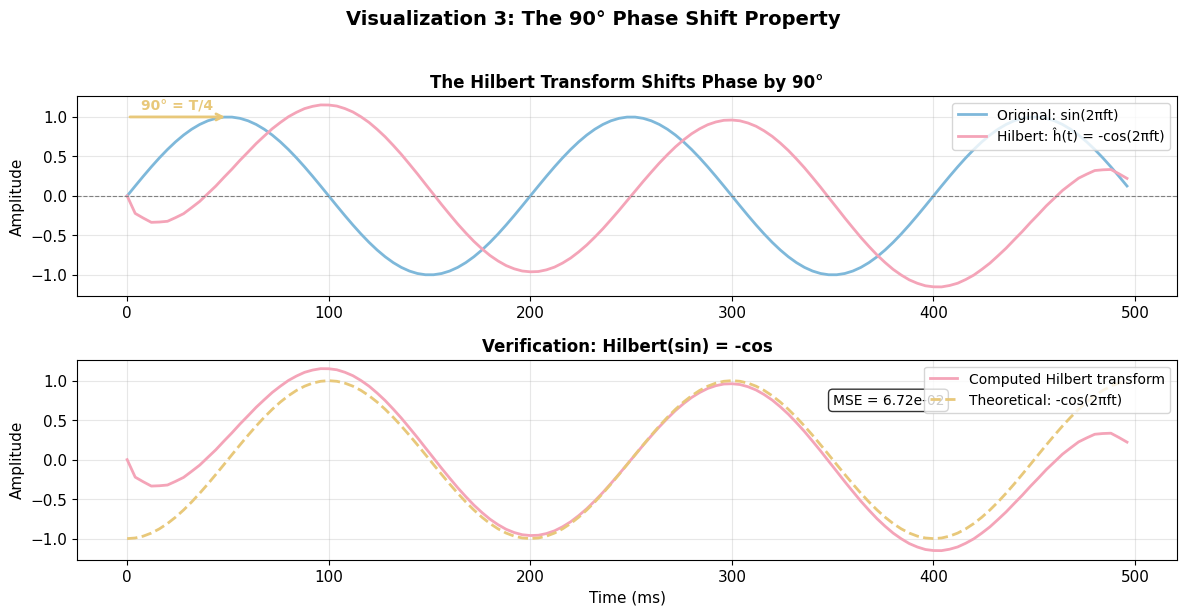

Mean Squared Error between computed and theoretical: 6.72e-02
The Hilbert transform of sin(t) is indeed -cos(t)!


In [5]:
# ============================================================================
# VISUALIZATION 3: The 90° Phase Shift
# ============================================================================

# Create a simple signal
fs = 250
duration = 0.5
t = np.arange(0, duration, 1/fs)
freq = 5  # Hz

# Original signal and its Hilbert transform
original = np.sin(2 * np.pi * freq * t)
analytic = hilbert(original)
hilbert_transformed = np.imag(analytic)

# Theoretical Hilbert transform of sin is -cos
theoretical = -np.cos(2 * np.pi * freq * t)

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Plot 1: Original and Hilbert transform
ax1 = axes[0]
ax1.plot(t * 1000, original, color=PRIMARY_BLUE, linewidth=2, label='Original: sin(2πft)')
ax1.plot(t * 1000, hilbert_transformed, color=SECONDARY_PINK, linewidth=2, 
         label='Hilbert: ĥ(t) = -cos(2πft)')
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('The Hilbert Transform Shifts Phase by 90°', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

# Mark the 90° phase shift
ax1.annotate('', xy=(50, 1), xytext=(0, 1),
             arrowprops=dict(arrowstyle='->', color=ACCENT_GOLD, lw=2))
ax1.text(25, 1.1, '90° = T/4', ha='center', fontsize=10, color=ACCENT_GOLD, fontweight='bold')

# Plot 2: Verification (should match theoretical)
ax2 = axes[1]
ax2.plot(t * 1000, hilbert_transformed, color=SECONDARY_PINK, linewidth=2, 
         label='Computed Hilbert transform')
ax2.plot(t * 1000, theoretical, color=ACCENT_GOLD, linewidth=2, linestyle='--',
         label='Theoretical: -cos(2πft)')
ax2.set_xlabel('Time (ms)', fontsize=11)
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Verification: Hilbert(sin) = -cos', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

# Show the error
mse = np.mean((hilbert_transformed - theoretical)**2)
ax2.text(350, 0.7, f'MSE = {mse:.2e}', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Visualization 3: The 90° Phase Shift Property', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Mean Squared Error between computed and theoretical: {mse:.2e}")
print("The Hilbert transform of sin(t) is indeed -cos(t)!")

---

## 5. Extracting the Envelope (Amplitude)

### Definition

The **instantaneous amplitude** (or envelope) is the magnitude of the analytic signal:

$$A(t) = |z(t)| = \sqrt{x(t)^2 + \hat{x}(t)^2}$$

### Physical Interpretation

The envelope captures the **slow fluctuations in signal strength**:
- For a pure sine wave: envelope is constant
- For an amplitude-modulated signal: envelope follows the modulation
- For a filtered EEG band: envelope represents "power" in that band over time

### Applications in Hyperscanning

Amplitude correlations are used in:
- **Envelope Correlation**: Pearson correlation between amplitude envelopes
- **Power Correlation**: Similar, but often squared envelopes
- **Amplitude Coupling**: Cross-correlation of envelopes at different lags

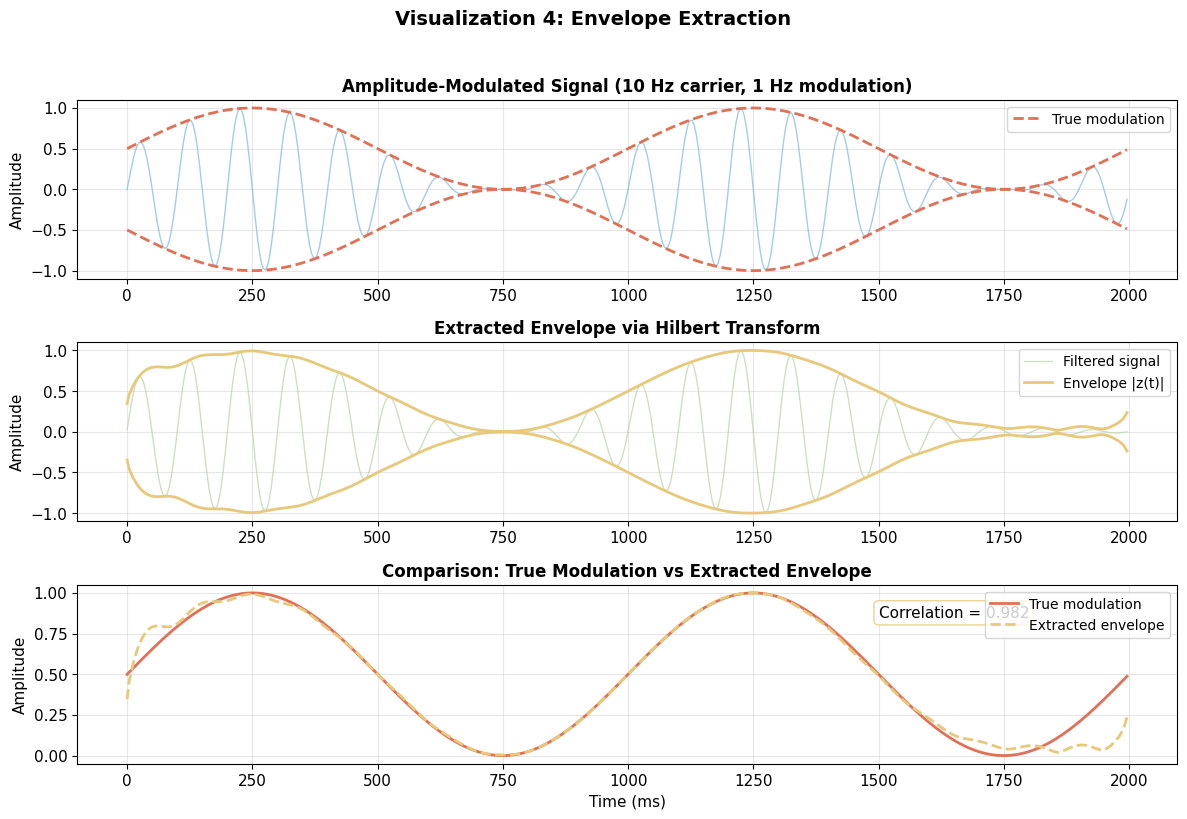

Correlation between true modulation and extracted envelope: 0.982
The envelope successfully captures the amplitude modulation!


In [6]:
# ============================================================================
# VISUALIZATION 4: Envelope Extraction
# ============================================================================

# Create an amplitude-modulated signal
fs = 250
duration = 2.0
t = np.arange(0, duration, 1/fs)

# Carrier frequency (10 Hz) with slow amplitude modulation (1 Hz)
carrier_freq = 10
modulation_freq = 1
modulation = 0.5 + 0.5 * np.sin(2 * np.pi * modulation_freq * t)  # Between 0 and 1
am_signal = modulation * np.sin(2 * np.pi * carrier_freq * t)

# Band-pass filter around carrier frequency
filtered_signal = bandpass_filter(am_signal, 8, 12, fs)

# Compute analytic signal and envelope
analytic = hilbert(filtered_signal)
envelope = np.abs(analytic)

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Plot 1: Original AM signal
ax1 = axes[0]
ax1.plot(t * 1000, am_signal, color=PRIMARY_BLUE, linewidth=1, alpha=0.7)
ax1.plot(t * 1000, modulation, color=PRIMARY_RED, linewidth=2, linestyle='--', 
         label='True modulation')
ax1.plot(t * 1000, -modulation, color=PRIMARY_RED, linewidth=2, linestyle='--')
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Amplitude-Modulated Signal (10 Hz carrier, 1 Hz modulation)', 
              fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Filtered signal with envelope
ax2 = axes[1]
ax2.plot(t * 1000, filtered_signal, color=PRIMARY_GREEN, linewidth=1, alpha=0.7,
         label='Filtered signal')
ax2.plot(t * 1000, envelope, color=ACCENT_GOLD, linewidth=2, 
         label='Envelope |z(t)|')
ax2.plot(t * 1000, -envelope, color=ACCENT_GOLD, linewidth=2)
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Extracted Envelope via Hilbert Transform', fontsize=12, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Envelope vs true modulation
ax3 = axes[2]
ax3.plot(t * 1000, modulation, color=PRIMARY_RED, linewidth=2, 
         label='True modulation')
ax3.plot(t * 1000, envelope, color=ACCENT_GOLD, linewidth=2, linestyle='--',
         label='Extracted envelope')
ax3.set_xlabel('Time (ms)', fontsize=11)
ax3.set_ylabel('Amplitude', fontsize=11)
ax3.set_title('Comparison: True Modulation vs Extracted Envelope', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)

# Compute correlation
correlation = np.corrcoef(modulation, envelope)[0, 1]
ax3.text(1500, 0.85, f'Correlation = {correlation:.3f}', fontsize=11,
         bbox=dict(boxstyle='round', facecolor='white', edgecolor=ACCENT_GOLD, alpha=0.8))

plt.suptitle('Visualization 4: Envelope Extraction', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Correlation between true modulation and extracted envelope: {correlation:.3f}")
print("The envelope successfully captures the amplitude modulation!")

---

## 6. Extracting Instantaneous Phase

### Definition

The **instantaneous phase** is the angle of the analytic signal:

$$\phi(t) = \arg(z(t)) = \text{atan2}(\hat{x}(t), x(t))$$

The result is in radians, ranging from $-\pi$ to $\pi$.

### Phase Wrapping

Since phase is circular, it "wraps" when it crosses $\pm\pi$. This is important to remember when:
- Computing phase differences
- Analyzing phase time series
- Calculating instantaneous frequency

### Applications in Hyperscanning

Phase synchronization metrics:
- **PLV (Phase Locking Value)**: Consistency of phase difference
- **PLI (Phase Lag Index)**: Asymmetry of phase lead/lag
- **wPLI (weighted PLI)**: Weighted by magnitude of imaginary coherence
- **Circular Statistics**: Mean phase, phase variance

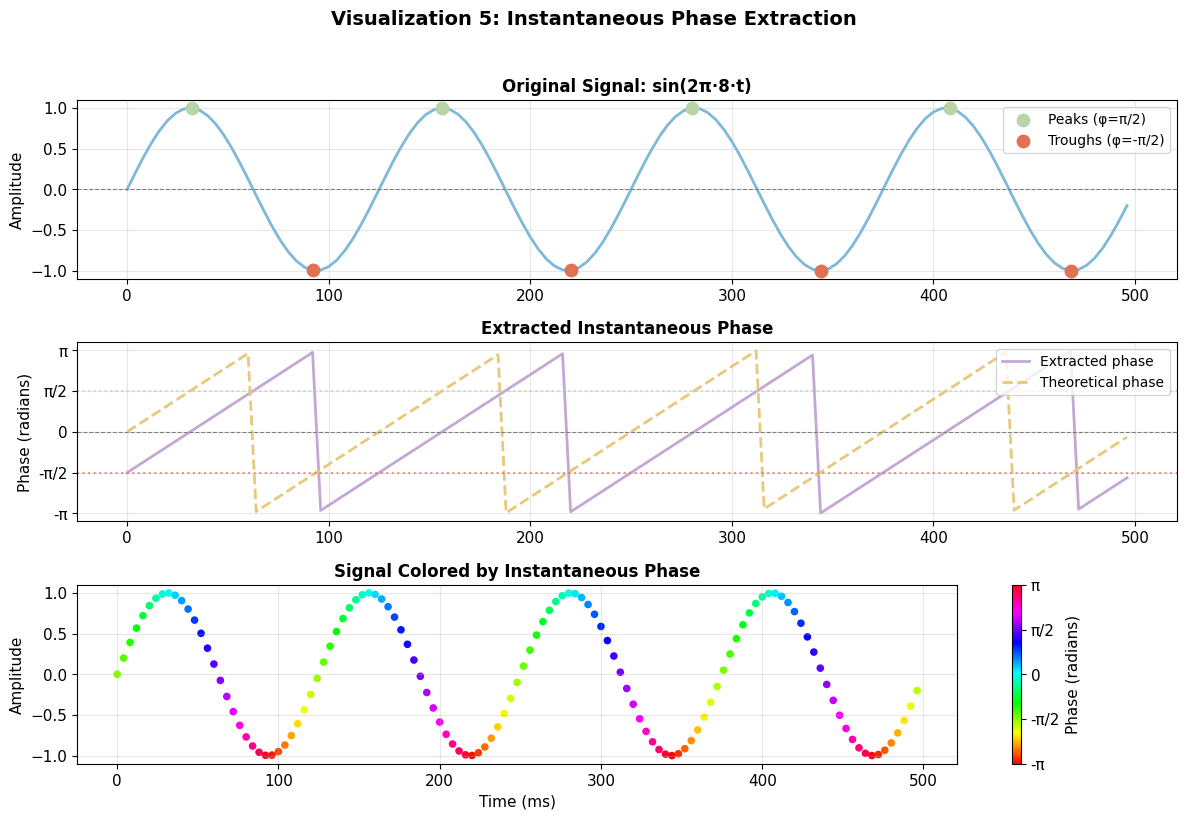

Phase wraps from +π to -π (or vice versa) — this is normal!
Notice: peaks correspond to phase π/2, troughs to phase -π/2.


In [7]:
# ============================================================================
# VISUALIZATION 5: Phase Extraction
# ============================================================================

# Create a simple signal
fs = 250
duration = 0.5
t = np.arange(0, duration, 1/fs)
freq = 8  # Hz

# Signal and analytic signal
signal_raw = np.sin(2 * np.pi * freq * t)
analytic = hilbert(signal_raw)
phase = np.angle(analytic)

# Theoretical phase (unwrapped)
theoretical_phase = 2 * np.pi * freq * t
theoretical_wrapped = np.mod(theoretical_phase + np.pi, 2 * np.pi) - np.pi

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Plot 1: Signal
ax1 = axes[0]
ax1.plot(t * 1000, signal_raw, color=PRIMARY_BLUE, linewidth=2)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Original Signal: sin(2π·8·t)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)

# Mark peaks and troughs
peak_times = np.where(np.diff(np.sign(np.diff(signal_raw))) < 0)[0] + 1
trough_times = np.where(np.diff(np.sign(np.diff(signal_raw))) > 0)[0] + 1
ax1.scatter(t[peak_times] * 1000, signal_raw[peak_times], color=PRIMARY_GREEN, s=80, 
            zorder=5, label='Peaks (φ=π/2)')
ax1.scatter(t[trough_times] * 1000, signal_raw[trough_times], color=PRIMARY_RED, s=80,
            zorder=5, label='Troughs (φ=-π/2)')
ax1.legend(loc='upper right', fontsize=10)

# Plot 2: Extracted phase
ax2 = axes[1]
ax2.plot(t * 1000, phase, color=ACCENT_PURPLE, linewidth=2, label='Extracted phase')
ax2.plot(t * 1000, theoretical_wrapped, color=ACCENT_GOLD, linewidth=2, linestyle='--',
         label='Theoretical phase')
ax2.set_ylabel('Phase (radians)', fontsize=11)
ax2.set_title('Extracted Instantaneous Phase', fontsize=12, fontweight='bold')
ax2.axhline(y=np.pi/2, color=PRIMARY_GREEN, linestyle=':', alpha=0.7)
ax2.axhline(y=-np.pi/2, color=PRIMARY_RED, linestyle=':', alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
ax2.set_ylim(-np.pi - 0.3, np.pi + 0.3)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

# Add pi labels
ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax2.set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'])

# Plot 3: Phase wrapped to color
ax3 = axes[2]
ax3.scatter(t * 1000, signal_raw, c=phase, cmap='hsv', s=20)
ax3.set_xlabel('Time (ms)', fontsize=11)
ax3.set_ylabel('Amplitude', fontsize=11)
ax3.set_title('Signal Colored by Instantaneous Phase', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap='hsv', norm=plt.Normalize(-np.pi, np.pi))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax3, label='Phase (radians)')
cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.set_ticklabels(['-π', '-π/2', '0', 'π/2', 'π'])

plt.suptitle('Visualization 5: Instantaneous Phase Extraction', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Phase wraps from +π to -π (or vice versa) — this is normal!")
print("Notice: peaks correspond to phase π/2, troughs to phase -π/2.")

---

## 7. The Narrowband Requirement

### Why Filtering is Essential

The Hilbert transform only produces **meaningful** results for **narrowband signals** — signals that contain a single dominant frequency or a narrow range of frequencies.

For broadband signals:
- The "instantaneous phase" and "amplitude" become mathematically defined but **physically meaningless**
- The envelope can become negative (which makes no physical sense)
- Phase estimates become unreliable

### The Rule of Thumb

A signal is considered narrowband if:

$$\frac{\Delta f}{f_c} < 0.5$$

where $\Delta f$ is the bandwidth and $f_c$ is the center frequency.

For EEG bands:
| Band | Range | Center | Bandwidth | Ratio |
|------|-------|--------|-----------|-------|
| Alpha | 8-13 Hz | 10.5 Hz | 5 Hz | 0.48 ✓ |
| Theta | 4-8 Hz | 6 Hz | 4 Hz | 0.67 ⚠️ |
| Beta | 13-30 Hz | 21.5 Hz | 17 Hz | 0.79 ✗ |

**Recommendation**: For broad bands like beta, consider subdividing (low-beta, high-beta).

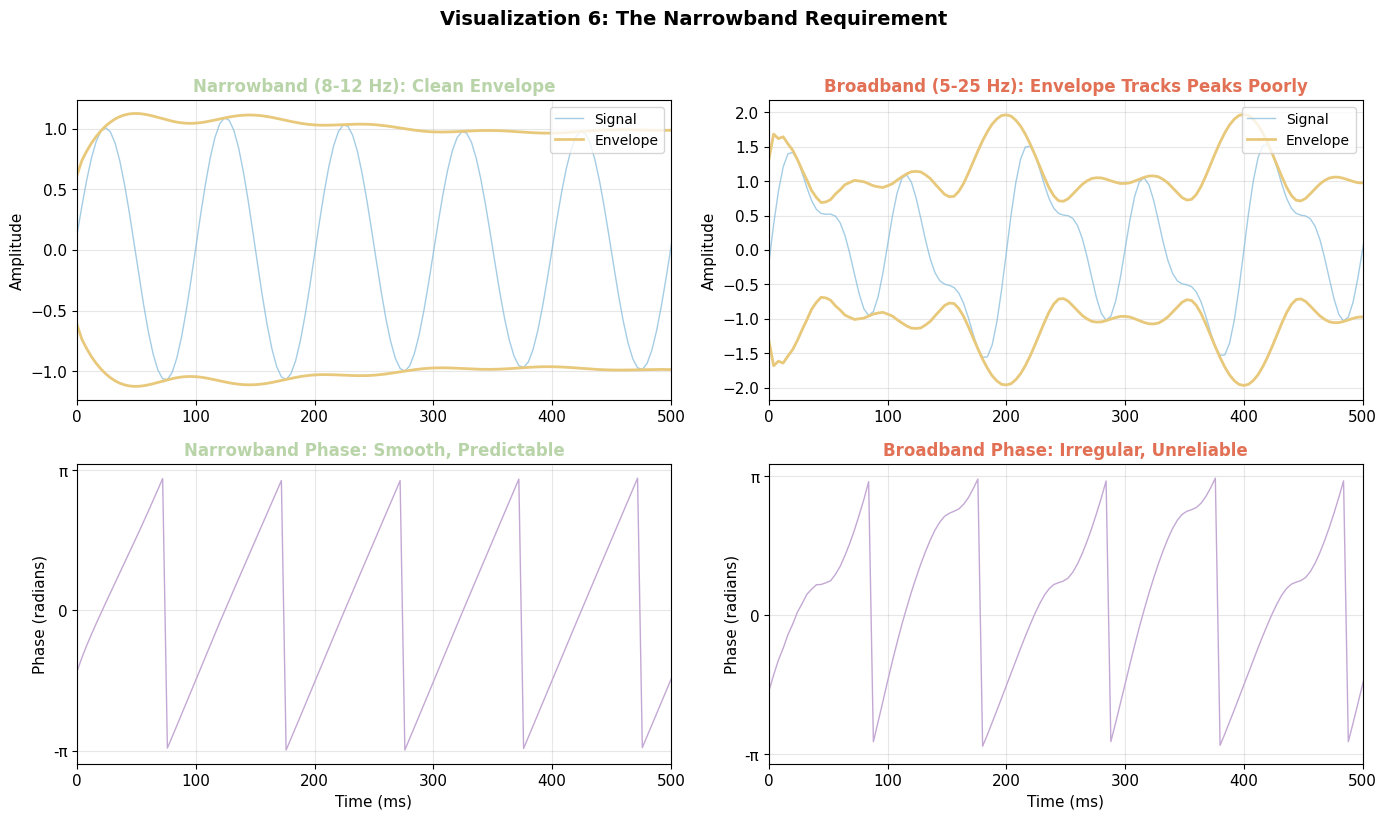

Narrowband: Δf/fc = 4/10 = 0.40 (< 0.5 ✓)
Broadband:  Δf/fc = 20/15 = 1.33 (> 0.5 ✗)

Always filter to a narrow band before applying the Hilbert transform!


In [8]:
# ============================================================================
# VISUALIZATION 6: Narrowband vs Broadband Hilbert Transform
# ============================================================================

# Create signals
fs = 250
duration = 2.0
t = np.arange(0, duration, 1/fs)

# Create composite signal (5 + 10 + 20 Hz)
composite = (np.sin(2 * np.pi * 5 * t) + 
             np.sin(2 * np.pi * 10 * t) + 
             0.5 * np.sin(2 * np.pi * 20 * t))

# Narrowband filtered (8-12 Hz) - centered on 10 Hz
narrowband = bandpass_filter(composite, 8, 12, fs)

# Broadband filtered (5-25 Hz) - wide range
broadband = bandpass_filter(composite, 5, 25, fs)

# Compute analytic signals
analytic_narrow = hilbert(narrowband)
analytic_broad = hilbert(broadband)

envelope_narrow = np.abs(analytic_narrow)
envelope_broad = np.abs(analytic_broad)
phase_narrow = np.angle(analytic_narrow)
phase_broad = np.angle(analytic_broad)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Narrowband signal + envelope
ax1 = axes[0, 0]
ax1.plot(t * 1000, narrowband, color=PRIMARY_BLUE, linewidth=1, alpha=0.7, label='Signal')
ax1.plot(t * 1000, envelope_narrow, color=ACCENT_GOLD, linewidth=2, label='Envelope')
ax1.plot(t * 1000, -envelope_narrow, color=ACCENT_GOLD, linewidth=2)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Narrowband (8-12 Hz): Clean Envelope', fontsize=12, fontweight='bold', color=PRIMARY_GREEN)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 500)

# Plot 2: Broadband signal + envelope
ax2 = axes[0, 1]
ax2.plot(t * 1000, broadband, color=PRIMARY_BLUE, linewidth=1, alpha=0.7, label='Signal')
ax2.plot(t * 1000, envelope_broad, color=ACCENT_GOLD, linewidth=2, label='Envelope')
ax2.plot(t * 1000, -envelope_broad, color=ACCENT_GOLD, linewidth=2)
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Broadband (5-25 Hz): Envelope Tracks Peaks Poorly', 
              fontsize=12, fontweight='bold', color=PRIMARY_RED)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 500)

# Plot 3: Narrowband phase
ax3 = axes[1, 0]
ax3.plot(t * 1000, phase_narrow, color=ACCENT_PURPLE, linewidth=1)
ax3.set_xlabel('Time (ms)', fontsize=11)
ax3.set_ylabel('Phase (radians)', fontsize=11)
ax3.set_title('Narrowband Phase: Smooth, Predictable', fontsize=12, fontweight='bold', color=PRIMARY_GREEN)
ax3.set_yticks([-np.pi, 0, np.pi])
ax3.set_yticklabels(['-π', '0', 'π'])
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, 500)

# Plot 4: Broadband phase
ax4 = axes[1, 1]
ax4.plot(t * 1000, phase_broad, color=ACCENT_PURPLE, linewidth=1)
ax4.set_xlabel('Time (ms)', fontsize=11)
ax4.set_ylabel('Phase (radians)', fontsize=11)
ax4.set_title('Broadband Phase: Irregular, Unreliable', 
              fontsize=12, fontweight='bold', color=PRIMARY_RED)
ax4.set_yticks([-np.pi, 0, np.pi])
ax4.set_yticklabels(['-π', '0', 'π'])
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, 500)

plt.suptitle('Visualization 6: The Narrowband Requirement', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Compute bandwidth ratios
narrow_bw = 12 - 8
narrow_center = 10
broad_bw = 25 - 5
broad_center = 15
print(f"Narrowband: Δf/fc = {narrow_bw}/{narrow_center} = {narrow_bw/narrow_center:.2f} (< 0.5 ✓)")
print(f"Broadband:  Δf/fc = {broad_bw}/{broad_center} = {broad_bw/broad_center:.2f} (> 0.5 ✗)")
print("\nAlways filter to a narrow band before applying the Hilbert transform!")

---

## 8. Complete Workflow — Filter → Hilbert → Extract

Now let's put it all together in a complete workflow for extracting amplitude and phase from a realistic signal:

### The Standard Pipeline

```
Raw Signal → Band-pass Filter → Hilbert Transform → Extract Amplitude/Phase
```

1. **Band-pass filter** the signal to the frequency band of interest
2. Apply **scipy.signal.hilbert()** to compute the analytic signal
3. Extract **amplitude** as `np.abs(analytic)`
4. Extract **phase** as `np.angle(analytic)`

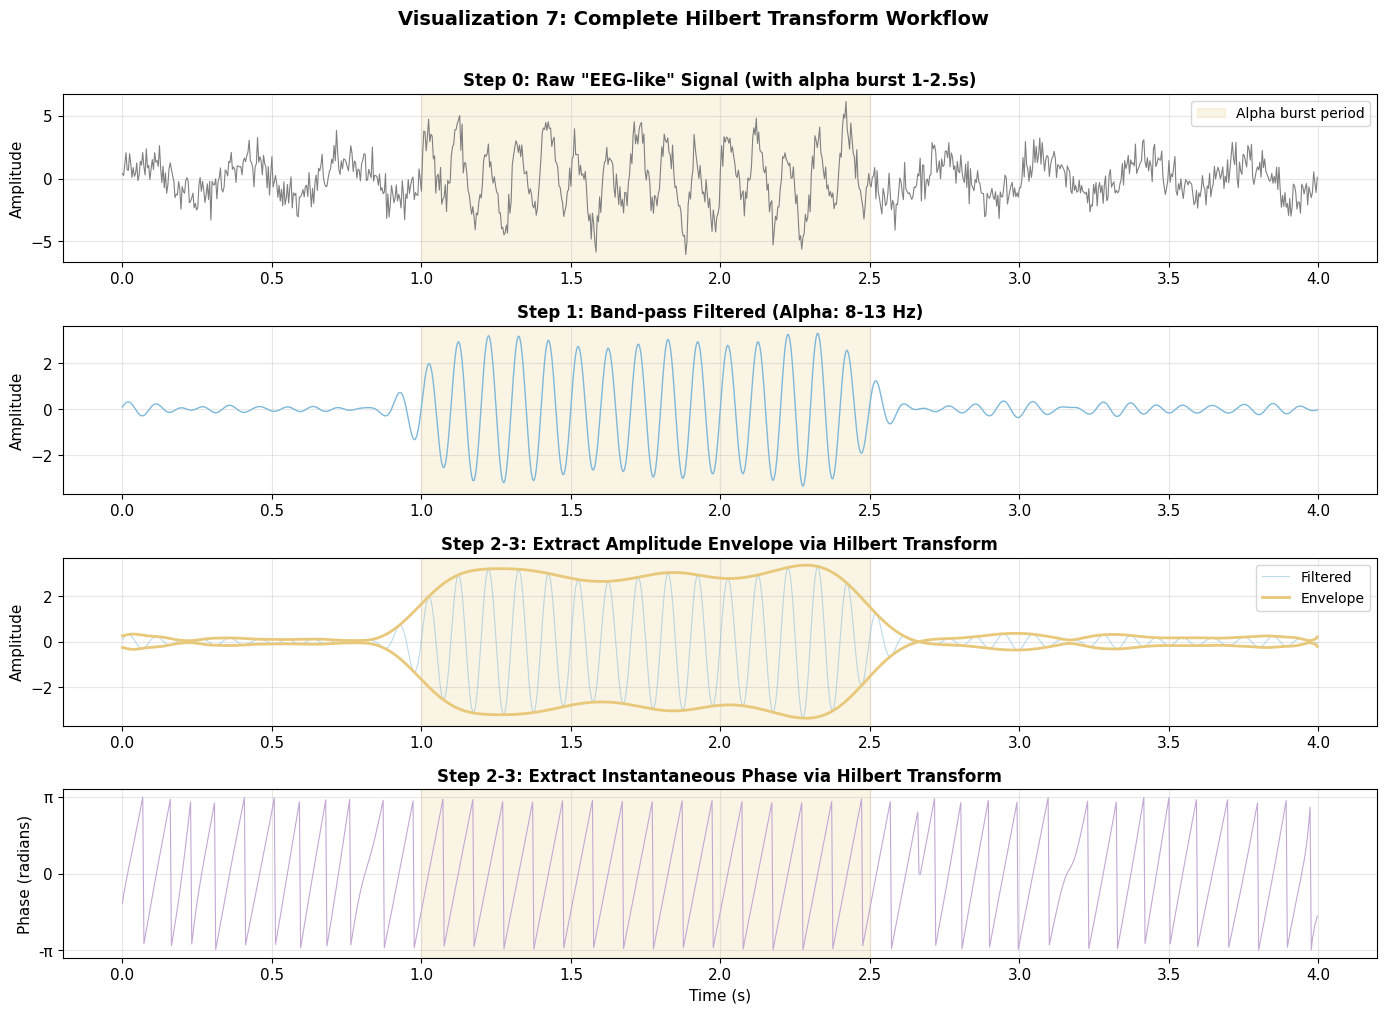

The envelope correctly captures the alpha burst (1-2.5s).
Phase is only meaningful during periods of sufficient amplitude.


In [9]:
# ============================================================================
# VISUALIZATION 7: Complete Workflow Demonstration
# ============================================================================

def extract_band_amplitude_phase(
    signal_data: NDArray[np.floating],
    low_freq: float,
    high_freq: float,
    fs: float
) -> Tuple[NDArray[np.floating], NDArray[np.floating], NDArray[np.floating]]:
    """
    Extract amplitude envelope and instantaneous phase from a signal.
    
    Parameters
    ----------
    signal_data : NDArray[np.floating]
        Input signal.
    low_freq : float
        Lower cutoff frequency for band-pass filter.
    high_freq : float
        Upper cutoff frequency for band-pass filter.
    fs : float
        Sampling frequency in Hz.
    
    Returns
    -------
    filtered : NDArray[np.floating]
        Band-pass filtered signal.
    amplitude : NDArray[np.floating]
        Instantaneous amplitude (envelope).
    phase : NDArray[np.floating]
        Instantaneous phase in radians.
    """
    # Step 1: Band-pass filter
    filtered = bandpass_filter(signal_data, low_freq, high_freq, fs)
    
    # Step 2: Compute analytic signal via Hilbert transform
    analytic = hilbert(filtered)
    
    # Step 3: Extract amplitude and phase
    amplitude = np.abs(analytic)
    phase = np.angle(analytic)
    
    return filtered, amplitude, phase


# Create a realistic-looking "EEG-like" signal
np.random.seed(42)
fs = 250
duration = 4.0
t = np.arange(0, duration, 1/fs)

# Mix of frequencies with varying amplitudes + noise
alpha_burst = np.zeros_like(t)
alpha_burst[(t > 1) & (t < 2.5)] = 3 * np.sin(2 * np.pi * 10 * t[(t > 1) & (t < 2.5)])

eeg_like = (
    1.5 * np.sin(2 * np.pi * 3 * t) +  # Delta/theta
    alpha_burst +  # Alpha burst
    0.5 * np.sin(2 * np.pi * 20 * t) +  # Beta
    0.8 * np.random.randn(len(t))  # Noise
)

# Apply the complete workflow for alpha band
filtered_alpha, amplitude_alpha, phase_alpha = extract_band_amplitude_phase(
    eeg_like, low_freq=8, high_freq=13, fs=fs
)

# Create figure
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Plot 1: Raw signal
ax1 = axes[0]
ax1.plot(t, eeg_like, color='gray', linewidth=0.8)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Step 0: Raw "EEG-like" Signal (with alpha burst 1-2.5s)', 
              fontsize=12, fontweight='bold')
ax1.axvspan(1, 2.5, alpha=0.2, color=ACCENT_GOLD, label='Alpha burst period')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Filtered signal
ax2 = axes[1]
ax2.plot(t, filtered_alpha, color=PRIMARY_BLUE, linewidth=1)
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Step 1: Band-pass Filtered (Alpha: 8-13 Hz)', fontsize=12, fontweight='bold')
ax2.axvspan(1, 2.5, alpha=0.2, color=ACCENT_GOLD)
ax2.grid(True, alpha=0.3)

# Plot 3: Amplitude envelope
ax3 = axes[2]
ax3.plot(t, filtered_alpha, color=PRIMARY_BLUE, linewidth=0.8, alpha=0.5, label='Filtered')
ax3.plot(t, amplitude_alpha, color=ACCENT_GOLD, linewidth=2, label='Envelope')
ax3.plot(t, -amplitude_alpha, color=ACCENT_GOLD, linewidth=2)
ax3.set_ylabel('Amplitude', fontsize=11)
ax3.set_title('Step 2-3: Extract Amplitude Envelope via Hilbert Transform', 
              fontsize=12, fontweight='bold')
ax3.axvspan(1, 2.5, alpha=0.2, color=ACCENT_GOLD)
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Instantaneous phase
ax4 = axes[3]
ax4.plot(t, phase_alpha, color=ACCENT_PURPLE, linewidth=0.8)
ax4.set_xlabel('Time (s)', fontsize=11)
ax4.set_ylabel('Phase (radians)', fontsize=11)
ax4.set_title('Step 2-3: Extract Instantaneous Phase via Hilbert Transform', 
              fontsize=12, fontweight='bold')
ax4.axvspan(1, 2.5, alpha=0.2, color=ACCENT_GOLD)
ax4.set_yticks([-np.pi, 0, np.pi])
ax4.set_yticklabels(['-π', '0', 'π'])
ax4.grid(True, alpha=0.3)

plt.suptitle('Visualization 7: Complete Hilbert Transform Workflow', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("The envelope correctly captures the alpha burst (1-2.5s).")
print("Phase is only meaningful during periods of sufficient amplitude.")

---

## 9. Instantaneous Frequency

### Definition

The **instantaneous frequency** is the rate of change of phase:

$$f_{inst}(t) = \frac{1}{2\pi} \frac{d\phi(t)}{dt}$$

In discrete time, we compute this as:

$$f_{inst}[n] = \frac{f_s}{2\pi} \cdot \Delta\phi[n]$$

where $\Delta\phi$ is the phase difference between consecutive samples (properly unwrapped).

### Interpretation

For a pure sine wave at frequency $f$, the instantaneous frequency is constant and equals $f$.

For modulated or non-stationary signals, the instantaneous frequency varies over time.

### Caution

Instantaneous frequency is **very sensitive to noise** and only meaningful for narrowband signals with sufficient amplitude.

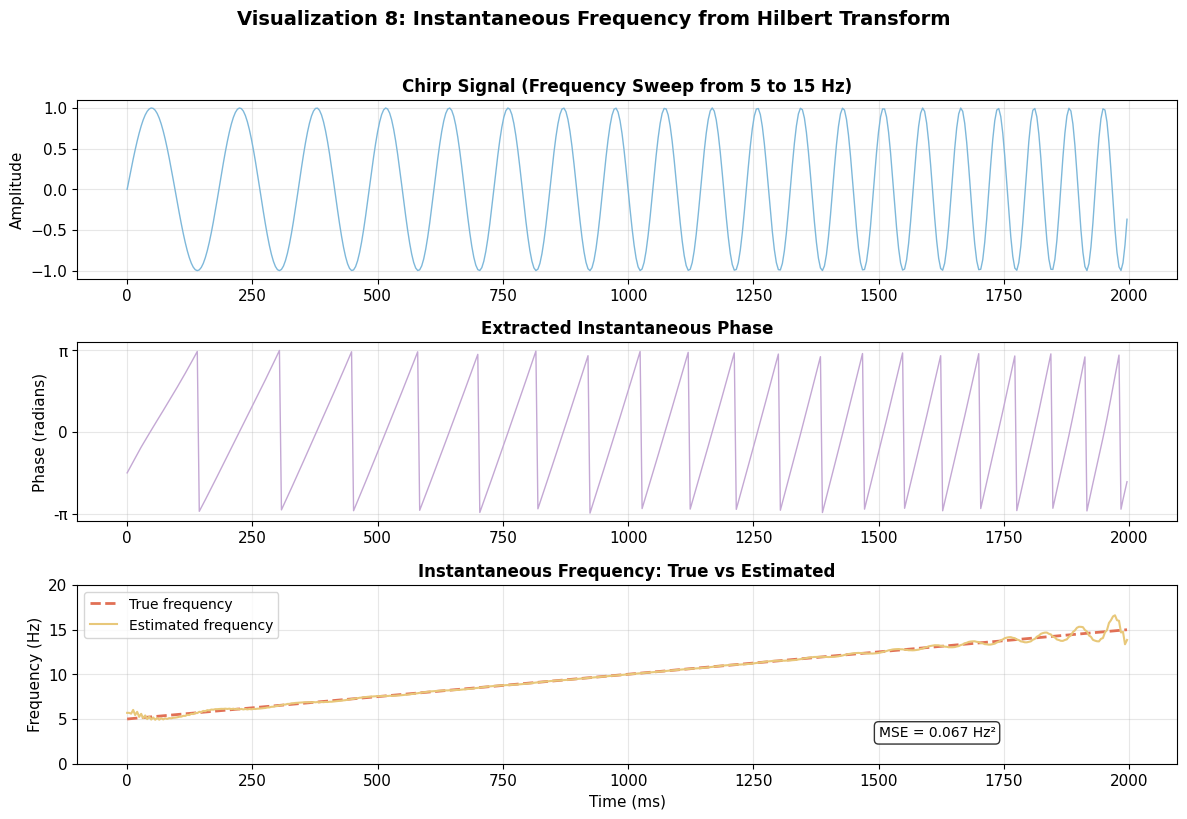

Mean Squared Error of frequency estimation: 0.067 Hz²
The Hilbert transform accurately tracks the changing frequency!


In [10]:
# ============================================================================
# VISUALIZATION 8: Instantaneous Frequency
# ============================================================================

def compute_instantaneous_frequency(
    phase: NDArray[np.floating],
    fs: float
) -> NDArray[np.floating]:
    """
    Compute instantaneous frequency from phase.
    
    Parameters
    ----------
    phase : NDArray[np.floating]
        Instantaneous phase in radians (wrapped).
    fs : float
        Sampling frequency in Hz.
    
    Returns
    -------
    inst_freq : NDArray[np.floating]
        Instantaneous frequency in Hz.
    """
    # Unwrap phase to remove discontinuities
    unwrapped_phase = np.unwrap(phase)
    
    # Compute derivative (phase difference)
    phase_diff = np.diff(unwrapped_phase)
    
    # Convert to frequency
    inst_freq = fs * phase_diff / (2 * np.pi)
    
    # Pad to match original length
    inst_freq = np.concatenate([[inst_freq[0]], inst_freq])
    
    return inst_freq


# Create a chirp signal (frequency sweep from 5 to 15 Hz)
fs = 250
duration = 2.0
t = np.arange(0, duration, 1/fs)

# Linear chirp: frequency increases linearly from f0 to f1
f0, f1 = 5, 15
k = (f1 - f0) / duration  # chirp rate
instantaneous_f_true = f0 + k * t  # True instantaneous frequency
phase_true = 2 * np.pi * (f0 * t + 0.5 * k * t**2)
chirp_signal = np.sin(phase_true)

# Compute analytic signal and extract phase
analytic = hilbert(chirp_signal)
phase_extracted = np.angle(analytic)
inst_freq = compute_instantaneous_frequency(phase_extracted, fs)

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Plot 1: Chirp signal
ax1 = axes[0]
ax1.plot(t * 1000, chirp_signal, color=PRIMARY_BLUE, linewidth=1)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Chirp Signal (Frequency Sweep from 5 to 15 Hz)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Extracted phase
ax2 = axes[1]
ax2.plot(t * 1000, phase_extracted, color=ACCENT_PURPLE, linewidth=1)
ax2.set_ylabel('Phase (radians)', fontsize=11)
ax2.set_title('Extracted Instantaneous Phase', fontsize=12, fontweight='bold')
ax2.set_yticks([-np.pi, 0, np.pi])
ax2.set_yticklabels(['-π', '0', 'π'])
ax2.grid(True, alpha=0.3)

# Plot 3: Instantaneous frequency
ax3 = axes[2]
ax3.plot(t * 1000, instantaneous_f_true, color=PRIMARY_RED, linewidth=2, 
         label='True frequency', linestyle='--')
ax3.plot(t * 1000, inst_freq, color=ACCENT_GOLD, linewidth=1.5, 
         label='Estimated frequency')
ax3.set_xlabel('Time (ms)', fontsize=11)
ax3.set_ylabel('Frequency (Hz)', fontsize=11)
ax3.set_title('Instantaneous Frequency: True vs Estimated', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left', fontsize=10)
ax3.set_ylim(0, 20)
ax3.grid(True, alpha=0.3)

# Show estimation error
mse = np.mean((inst_freq - instantaneous_f_true)**2)
ax3.text(1500, 3, f'MSE = {mse:.3f} Hz²', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.suptitle('Visualization 8: Instantaneous Frequency from Hilbert Transform', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"Mean Squared Error of frequency estimation: {mse:.3f} Hz²")
print("The Hilbert transform accurately tracks the changing frequency!")

---

## 10. Edge Effects and Padding

### The Problem

The Hilbert transform is computed via FFT, which assumes the signal is periodic. At the **edges** of a finite signal, this assumption fails, causing:
- Distorted envelope near the beginning and end
- Phase discontinuities
- "Gibbs ringing" artifacts

### Solutions

1. **Zero-padding**: Extend the signal with zeros before computing
2. **Reflection padding**: Mirror the signal at edges
3. **Trim edges**: Discard a few samples at the boundaries
4. **Windowing**: Apply a taper function before computing

### Practical Recommendation

For EEG analysis, **trim the first and last ~3 cycles** of the center frequency to avoid edge artifacts.

For 10 Hz alpha: trim ~300 ms from each end.

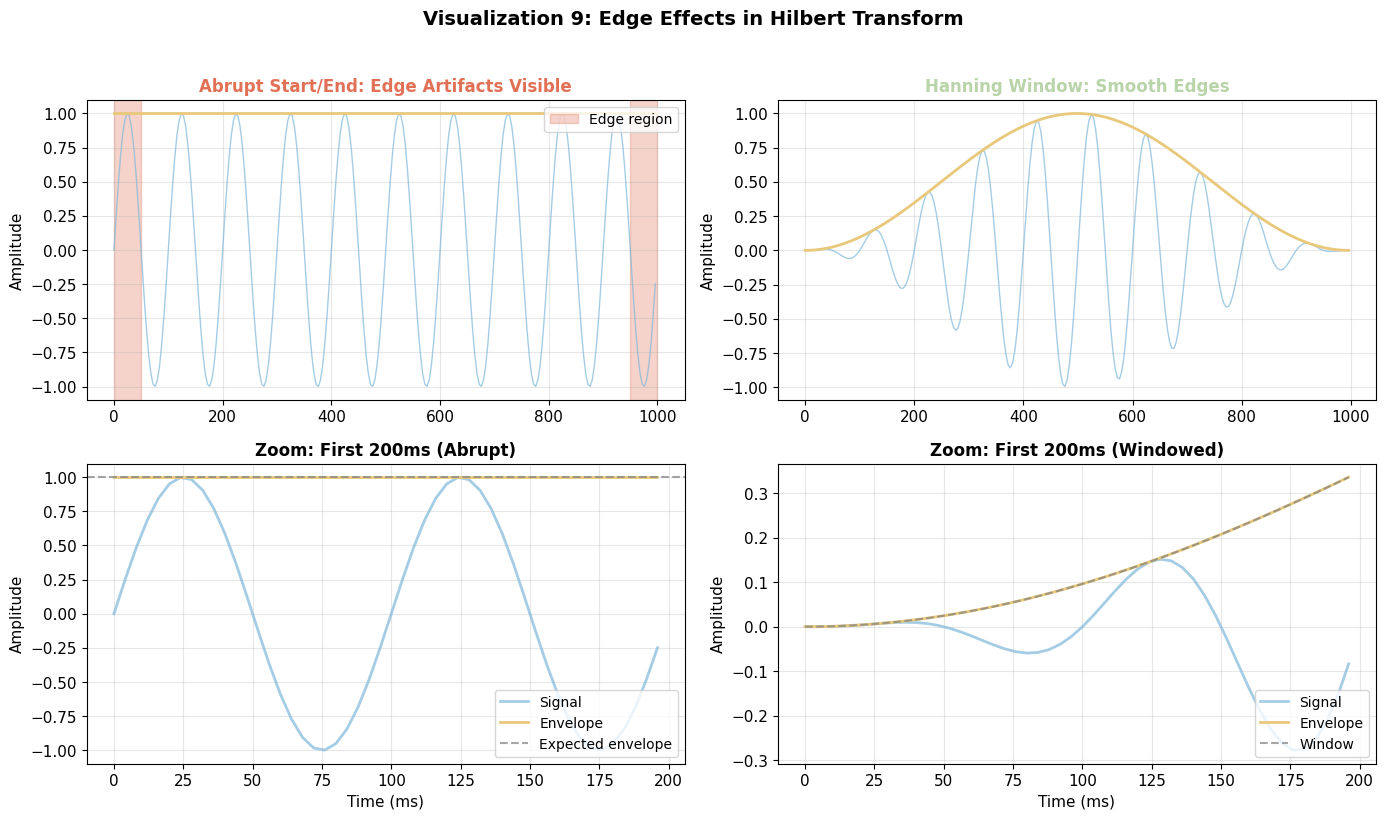

Edge effects: The envelope deviates from expected values at signal boundaries.
Solutions: Apply windowing, zero-padding, or trim edge samples.


In [11]:
# ============================================================================
# VISUALIZATION 9: Edge Effects
# ============================================================================

# Create a clean signal
fs = 250
duration = 1.0
t = np.arange(0, duration, 1/fs)
freq = 10

# Signal that abruptly starts and ends
abrupt_signal = np.sin(2 * np.pi * freq * t)

# Windowed signal (smooth start and end)
window = np.hanning(len(t))
windowed_signal = abrupt_signal * window

# Compute analytic signals
analytic_abrupt = hilbert(abrupt_signal)
analytic_windowed = hilbert(windowed_signal)

envelope_abrupt = np.abs(analytic_abrupt)
envelope_windowed = np.abs(analytic_windowed)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Abrupt signal
ax1 = axes[0, 0]
ax1.plot(t * 1000, abrupt_signal, color=PRIMARY_BLUE, linewidth=1, alpha=0.7)
ax1.plot(t * 1000, envelope_abrupt, color=ACCENT_GOLD, linewidth=2)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Abrupt Start/End: Edge Artifacts Visible', fontsize=12, fontweight='bold', color=PRIMARY_RED)
ax1.axvspan(0, 50, alpha=0.3, color=PRIMARY_RED, label='Edge region')
ax1.axvspan(950, 1000, alpha=0.3, color=PRIMARY_RED)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Windowed signal
ax2 = axes[0, 1]
ax2.plot(t * 1000, windowed_signal, color=PRIMARY_BLUE, linewidth=1, alpha=0.7)
ax2.plot(t * 1000, envelope_windowed, color=ACCENT_GOLD, linewidth=2)
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Hanning Window: Smooth Edges', fontsize=12, fontweight='bold', color=PRIMARY_GREEN)
ax2.grid(True, alpha=0.3)

# Plot 3: Zoom on edge - abrupt
ax3 = axes[1, 0]
ax3.plot(t[:50] * 1000, abrupt_signal[:50], color=PRIMARY_BLUE, linewidth=2, alpha=0.7, label='Signal')
ax3.plot(t[:50] * 1000, envelope_abrupt[:50], color=ACCENT_GOLD, linewidth=2, label='Envelope')
ax3.axhline(y=1, color='gray', linestyle='--', alpha=0.7, label='Expected envelope')
ax3.set_xlabel('Time (ms)', fontsize=11)
ax3.set_ylabel('Amplitude', fontsize=11)
ax3.set_title('Zoom: First 200ms (Abrupt)', fontsize=12, fontweight='bold')
ax3.legend(loc='lower right', fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Zoom on edge - windowed
ax4 = axes[1, 1]
ax4.plot(t[:50] * 1000, windowed_signal[:50], color=PRIMARY_BLUE, linewidth=2, alpha=0.7, label='Signal')
ax4.plot(t[:50] * 1000, envelope_windowed[:50], color=ACCENT_GOLD, linewidth=2, label='Envelope')
ax4.plot(t[:50] * 1000, window[:50], color='gray', linestyle='--', alpha=0.7, label='Window')
ax4.set_xlabel('Time (ms)', fontsize=11)
ax4.set_ylabel('Amplitude', fontsize=11)
ax4.set_title('Zoom: First 200ms (Windowed)', fontsize=12, fontweight='bold')
ax4.legend(loc='lower right', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.suptitle('Visualization 9: Edge Effects in Hilbert Transform', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Edge effects: The envelope deviates from expected values at signal boundaries.")
print("Solutions: Apply windowing, zero-padding, or trim edge samples.")

---

## 11. Alternative Approaches — Wavelet Transform

While the Hilbert transform is the standard approach, there are alternatives:

### Wavelet Transform

**Advantages**:
- Better time-frequency localization
- Naturally provides amplitude and phase
- No explicit filtering required
- Works with non-stationary signals

**Disadvantages**:
- More computationally expensive
- Choice of wavelet affects results
- Edge effects still present

### Comparison

| Feature | Hilbert | Wavelet |
|---------|---------|---------|
| Time resolution | Fixed | Adaptive |
| Frequency resolution | Fixed | Adaptive |
| Computational cost | Low | Medium |
| Implementation | Simple | Complex |
| Phase extraction | Direct | Direct |

We'll explore wavelets in detail in notebook **B04**.

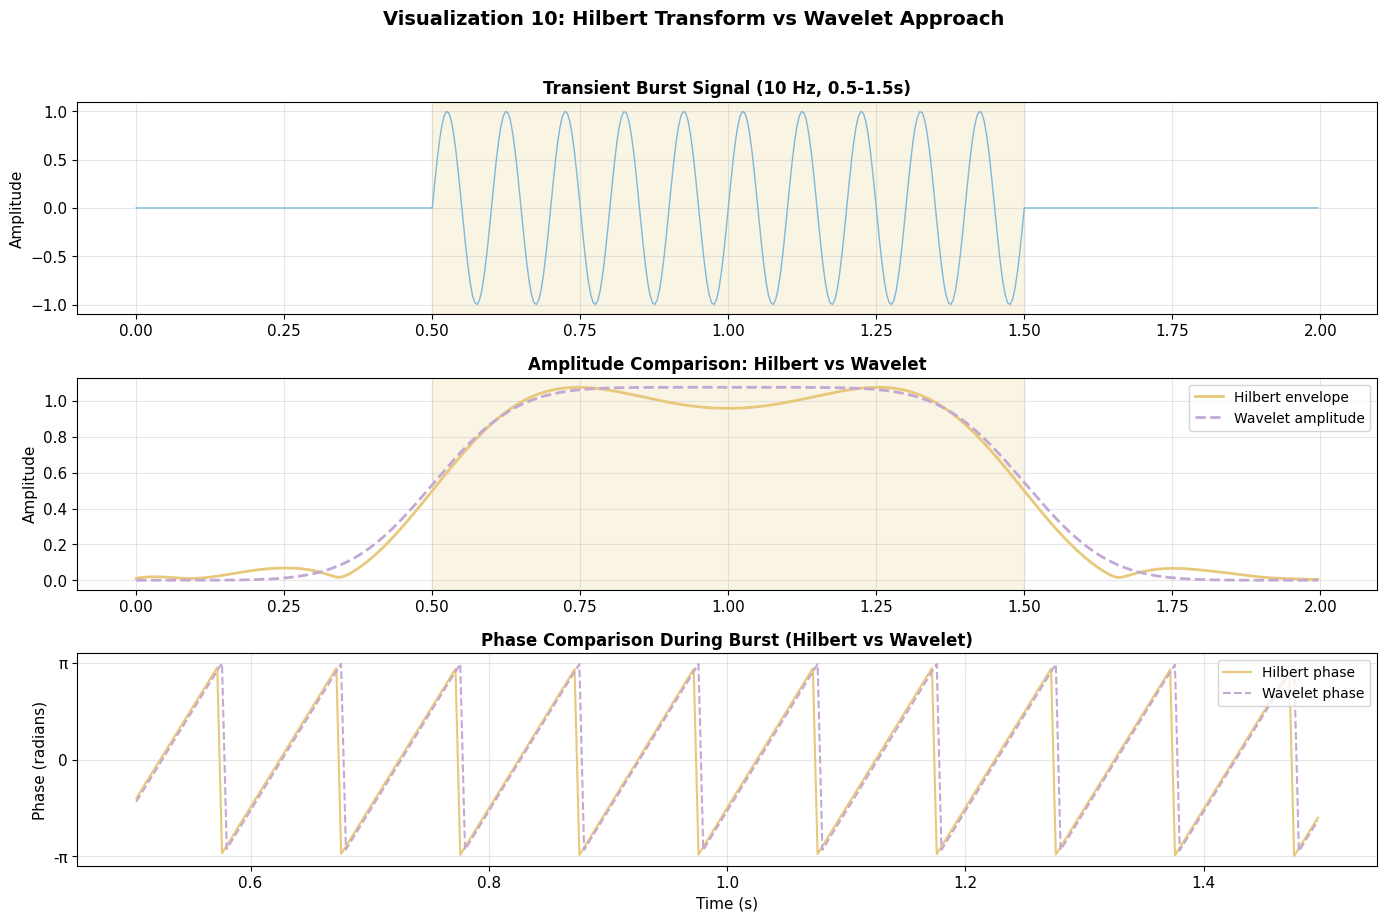

Both methods track the burst, but wavelets provide better time localization.
Hilbert is simpler; wavelets are more flexible for non-stationary signals.


In [13]:
# ============================================================================
# VISUALIZATION 10: Hilbert vs Wavelet Comparison
# ============================================================================

def wavelet_amplitude_phase(
    signal_data: NDArray[np.floating],
    freq: float,
    fs: float,
    n_cycles: int = 7
) -> Tuple[NDArray[np.floating], NDArray[np.floating]]:
    """
    Extract amplitude and phase using Morlet wavelet.
    
    Parameters
    ----------
    signal_data : NDArray[np.floating]
        Input signal.
    freq : float
        Center frequency for wavelet.
    fs : float
        Sampling frequency in Hz.
    n_cycles : int
        Number of cycles in wavelet.
    
    Returns
    -------
    amplitude : NDArray[np.floating]
        Amplitude from wavelet transform.
    phase : NDArray[np.floating]
        Phase from wavelet transform.
    """
    # Create complex Morlet wavelet
    sigma = n_cycles / (2 * np.pi * freq)
    
    # Wavelet duration (4 standard deviations on each side)
    wavelet_duration = 2 * 4 * sigma
    wavelet_samples = int(wavelet_duration * fs)
    if wavelet_samples % 2 == 0:
        wavelet_samples += 1
    
    # Create wavelet time vector centered at 0
    t_wavelet = np.arange(wavelet_samples) / fs - wavelet_duration / 2
    
    # Create complex Morlet wavelet
    wavelet = np.exp(1j * 2 * np.pi * freq * t_wavelet) * np.exp(-t_wavelet**2 / (2 * sigma**2))
    wavelet = wavelet / np.sqrt(sigma * np.sqrt(np.pi))
    
    # Convolve signal with wavelet
    convolved = signal.convolve(signal_data, wavelet, mode='same')
    
    amplitude = np.abs(convolved)
    phase = np.angle(convolved)
    
    return amplitude, phase


# Create a transient signal (burst)
fs = 250
duration = 2.0
t = np.arange(0, duration, 1/fs)
freq = 10

# Signal with transient burst
burst_signal = np.zeros_like(t)
burst_mask = (t > 0.5) & (t < 1.5)
burst_signal[burst_mask] = np.sin(2 * np.pi * freq * t[burst_mask])

# Hilbert approach
filtered_hilbert = bandpass_filter(burst_signal, 8, 12, fs)
analytic_hilbert = hilbert(filtered_hilbert)
amp_hilbert = np.abs(analytic_hilbert)
phase_hilbert = np.angle(analytic_hilbert)

# Wavelet approach
amp_wavelet, phase_wavelet = wavelet_amplitude_phase(burst_signal, freq, fs)

# Normalize for comparison
amp_wavelet_norm = amp_wavelet / np.max(amp_wavelet) * np.max(amp_hilbert)

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(14, 9))

# Plot 1: Signal
ax1 = axes[0]
ax1.plot(t, burst_signal, color=PRIMARY_BLUE, linewidth=1)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Transient Burst Signal (10 Hz, 0.5-1.5s)', fontsize=12, fontweight='bold')
ax1.axvspan(0.5, 1.5, alpha=0.2, color=ACCENT_GOLD)
ax1.grid(True, alpha=0.3)

# Plot 2: Amplitude comparison
ax2 = axes[1]
ax2.plot(t, amp_hilbert, color=ACCENT_GOLD, linewidth=2, label='Hilbert envelope')
ax2.plot(t, amp_wavelet_norm, color=ACCENT_PURPLE, linewidth=2, linestyle='--', 
         label='Wavelet amplitude')
ax2.set_ylabel('Amplitude', fontsize=11)
ax2.set_title('Amplitude Comparison: Hilbert vs Wavelet', fontsize=12, fontweight='bold')
ax2.axvspan(0.5, 1.5, alpha=0.2, color=ACCENT_GOLD)
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Phase comparison (only during burst)
ax3 = axes[2]
ax3.plot(t[burst_mask], phase_hilbert[burst_mask], color=ACCENT_GOLD, linewidth=1.5, 
         label='Hilbert phase')
ax3.plot(t[burst_mask], phase_wavelet[burst_mask], color=ACCENT_PURPLE, linewidth=1.5, 
         linestyle='--', label='Wavelet phase')
ax3.set_xlabel('Time (s)', fontsize=11)
ax3.set_ylabel('Phase (radians)', fontsize=11)
ax3.set_title('Phase Comparison During Burst (Hilbert vs Wavelet)', fontsize=12, fontweight='bold')
ax3.set_yticks([-np.pi, 0, np.pi])
ax3.set_yticklabels(['-π', '0', 'π'])
ax3.legend(loc='upper right', fontsize=10)
ax3.grid(True, alpha=0.3)

plt.suptitle('Visualization 10: Hilbert Transform vs Wavelet Approach', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("Both methods track the burst, but wavelets provide better time localization.")
print("Hilbert is simpler; wavelets are more flexible for non-stationary signals.")

---

## 12. Phase Synchronization Preview

The Hilbert transform enables **phase synchronization** analysis — the foundation of many hyperscanning connectivity metrics.

### Key Concept: Phase Locking

Two signals are **phase-locked** if their phase difference remains constant (or nearly constant) over time:

$$\Delta\phi(t) = \phi_1(t) - \phi_2(t) \approx \text{constant}$$

### Preview of Metrics

| Metric | Formula | Range | Key Feature |
|--------|---------|-------|-------------|
| **PLV** | $\|E[e^{i\Delta\phi}]\|$ | [0, 1] | Measures consistency |
| **PLI** | $\|E[\text{sign}(\Delta\phi)]\|$ | [0, 1] | Ignores zero-lag |
| **wPLI** | Weighted by imaginary coherence | [0, 1] | Robust to noise |

We'll explore these metrics in detail in notebook series **G** (Phase-based connectivity).

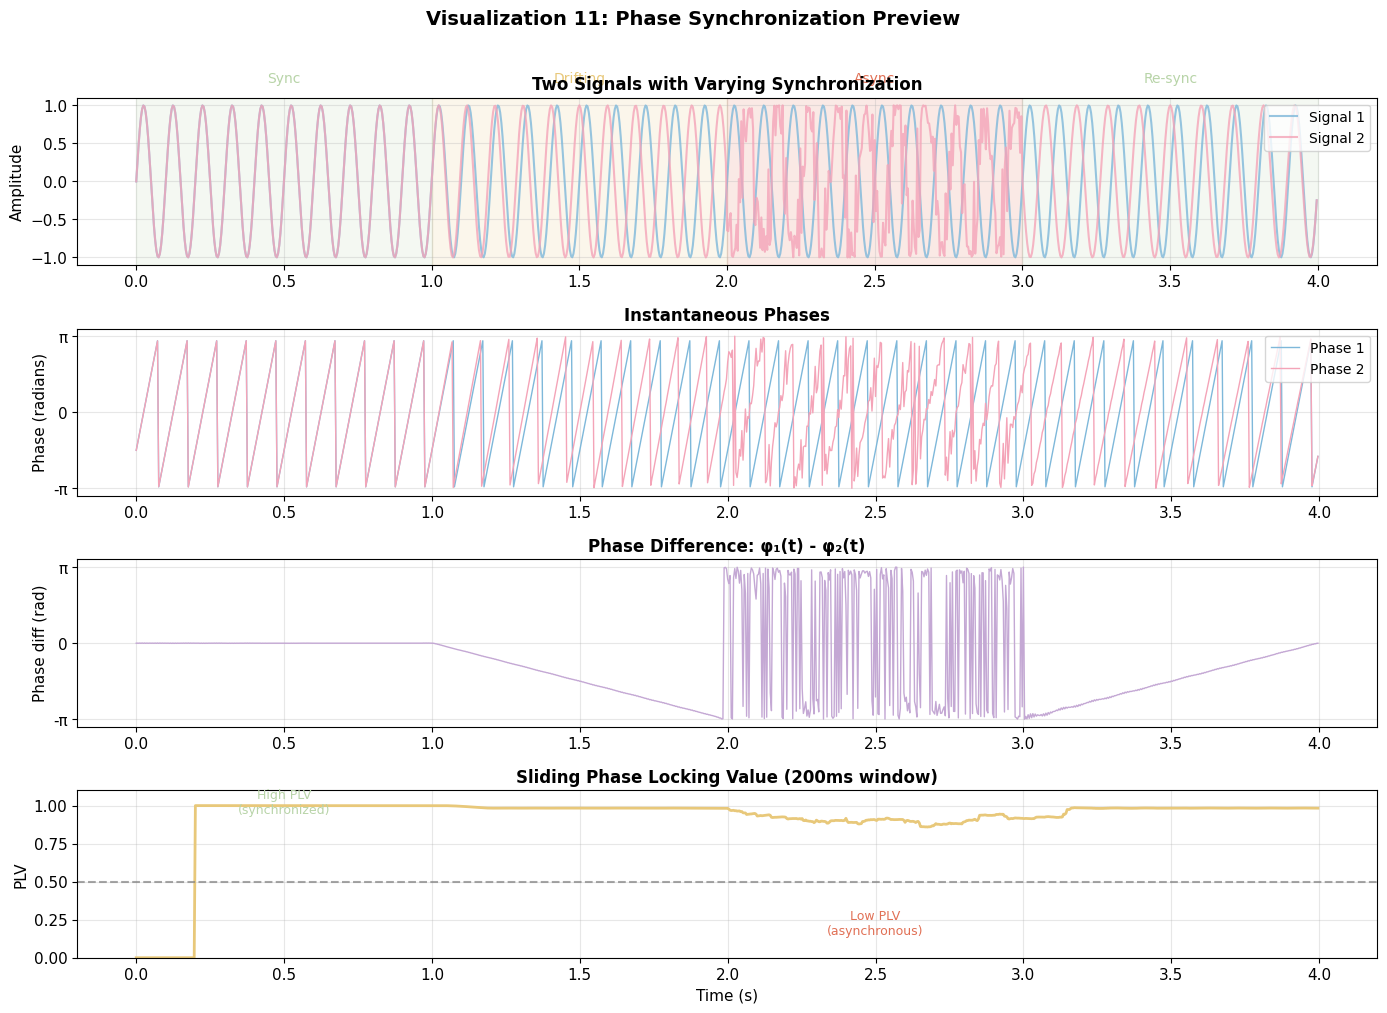

PLV (Phase Locking Value) quantifies how consistent the phase difference is.
High PLV = synchronized oscillations; Low PLV = independent oscillations.


In [14]:
# ============================================================================
# VISUALIZATION 11: Phase Synchronization Preview
# ============================================================================

# Create two signals with varying phase synchronization
fs = 250
duration = 4.0
t = np.arange(0, duration, 1/fs)
freq = 10

# Signal 1: Reference
signal1 = np.sin(2 * np.pi * freq * t)

# Signal 2: Starts synchronized, then desynchronizes, then synchronizes again
phase_offset = np.zeros_like(t)
phase_offset[(t > 1) & (t < 2)] = np.linspace(0, np.pi, np.sum((t > 1) & (t < 2)))
phase_offset[(t >= 2) & (t < 3)] = np.pi + 0.5 * np.random.randn(np.sum((t >= 2) & (t < 3)))
phase_offset[t >= 3] = np.linspace(np.pi, 0, np.sum(t >= 3))

signal2 = np.sin(2 * np.pi * freq * t + phase_offset)

# Compute analytic signals and phases
analytic1 = hilbert(signal1)
analytic2 = hilbert(signal2)
phase1 = np.angle(analytic1)
phase2 = np.angle(analytic2)

# Phase difference (circular)
phase_diff = np.angle(np.exp(1j * (phase1 - phase2)))

# Compute sliding PLV (200ms window)
window_samples = int(0.2 * fs)
plv = np.zeros(len(t))
for i in range(window_samples, len(t)):
    segment = phase_diff[i - window_samples:i]
    plv[i] = np.abs(np.mean(np.exp(1j * segment)))

# Create figure
fig, axes = plt.subplots(4, 1, figsize=(14, 10))

# Plot 1: Both signals
ax1 = axes[0]
ax1.plot(t, signal1, color=PRIMARY_BLUE, linewidth=1.5, label='Signal 1', alpha=0.8)
ax1.plot(t, signal2, color=SECONDARY_PINK, linewidth=1.5, label='Signal 2', alpha=0.8)
ax1.set_ylabel('Amplitude', fontsize=11)
ax1.set_title('Two Signals with Varying Synchronization', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(True, alpha=0.3)

# Add period labels
for start, end, label, color in [(0, 1, 'Sync', PRIMARY_GREEN), 
                                   (1, 2, 'Drifting', ACCENT_GOLD),
                                   (2, 3, 'Async', PRIMARY_RED),
                                   (3, 4, 'Re-sync', PRIMARY_GREEN)]:
    ax1.axvspan(start, end, alpha=0.15, color=color)
    ax1.text((start + end) / 2, 1.3, label, ha='center', fontsize=10, color=color)

# Plot 2: Phases
ax2 = axes[1]
ax2.plot(t, phase1, color=PRIMARY_BLUE, linewidth=1, label='Phase 1')
ax2.plot(t, phase2, color=SECONDARY_PINK, linewidth=1, label='Phase 2')
ax2.set_ylabel('Phase (radians)', fontsize=11)
ax2.set_title('Instantaneous Phases', fontsize=12, fontweight='bold')
ax2.set_yticks([-np.pi, 0, np.pi])
ax2.set_yticklabels(['-π', '0', 'π'])
ax2.legend(loc='upper right', fontsize=10)
ax2.grid(True, alpha=0.3)

# Plot 3: Phase difference
ax3 = axes[2]
ax3.plot(t, phase_diff, color=ACCENT_PURPLE, linewidth=1)
ax3.set_ylabel('Phase diff (rad)', fontsize=11)
ax3.set_title('Phase Difference: φ₁(t) - φ₂(t)', fontsize=12, fontweight='bold')
ax3.set_yticks([-np.pi, 0, np.pi])
ax3.set_yticklabels(['-π', '0', 'π'])
ax3.grid(True, alpha=0.3)

# Plot 4: PLV
ax4 = axes[3]
ax4.plot(t, plv, color=ACCENT_GOLD, linewidth=2)
ax4.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7)
ax4.set_xlabel('Time (s)', fontsize=11)
ax4.set_ylabel('PLV', fontsize=11)
ax4.set_title('Sliding Phase Locking Value (200ms window)', fontsize=12, fontweight='bold')
ax4.set_ylim(0, 1.1)
ax4.grid(True, alpha=0.3)

# Add annotations
ax4.text(0.5, 0.95, 'High PLV\n(synchronized)', ha='center', fontsize=9, color=PRIMARY_GREEN)
ax4.text(2.5, 0.15, 'Low PLV\n(asynchronous)', ha='center', fontsize=9, color=PRIMARY_RED)

plt.suptitle('Visualization 11: Phase Synchronization Preview', 
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("PLV (Phase Locking Value) quantifies how consistent the phase difference is.")
print("High PLV = synchronized oscillations; Low PLV = independent oscillations.")

---

## 13. Hands-On Exercises

Practice the concepts learned in this notebook.

### Exercise 1: Envelope Verification

Create a 10 Hz sine wave with time-varying amplitude (amplitude modulation at 1 Hz).
Extract the envelope using Hilbert transform and verify it matches the known modulation pattern.

**Tasks:**
1. Create an AM signal: `modulation(t) * sin(2π * 10 * t)` where modulation is a slow function
2. Extract envelope using Hilbert transform
3. Compare extracted envelope to original modulation function
4. Compute and report the correlation

In [ ]:
# ============================================================================
# EXERCISE 1: Your code here
# ============================================================================

# Parameters
fs_ex1 = 250
duration_ex1 = 3.0
t_ex1 = np.arange(0, duration_ex1, 1/fs_ex1)

# TODO: Create modulation function (e.g., 0.5 + 0.5 * sin(2π * 1 * t))
# modulation_ex1 = ...

# TODO: Create AM signal (carrier at 10 Hz)
# am_signal_ex1 = ...

# TODO: Extract envelope using Hilbert transform
# envelope_ex1 = ...

# TODO: Plot comparison and compute correlation
# ...

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Parameters
fs_ex1 = 250
duration_ex1 = 3.0
t_ex1 = np.arange(0, duration_ex1, 1/fs_ex1)

# Create modulation function (slow oscillation between 0.2 and 1)
modulation_ex1 = 0.6 + 0.4 * np.sin(2 * np.pi * 1 * t_ex1)

# Create AM signal (carrier at 10 Hz)
am_signal_ex1 = modulation_ex1 * np.sin(2 * np.pi * 10 * t_ex1)

# Extract envelope using Hilbert transform
analytic_ex1 = hilbert(am_signal_ex1)
envelope_ex1 = np.abs(analytic_ex1)

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t_ex1, am_signal_ex1, color=PRIMARY_BLUE, alpha=0.5, label='AM Signal')
ax.plot(t_ex1, modulation_ex1, color=PRIMARY_RED, linewidth=2, label='True modulation')
ax.plot(t_ex1, envelope_ex1, color=ACCENT_GOLD, linewidth=2, linestyle='--', label='Extracted envelope')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Exercise 1: Envelope Verification')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

# Compute correlation
correlation_ex1 = np.corrcoef(modulation_ex1, envelope_ex1)[0, 1]
print(f"Correlation between true modulation and extracted envelope: {correlation_ex1:.4f}")
```

**Expected result**: Correlation should be very close to 1.0 (typically > 0.99), confirming that the Hilbert envelope accurately captures the amplitude modulation.

</details>

### Exercise 2: Narrowband Requirement Demonstration

Create a signal with two components (8 Hz and 12 Hz). Apply Hilbert directly (no filtering) and observe invalid results. Then filter to each component separately and observe valid envelopes.

**Tasks:**
1. Create composite signal: `sin(2π * 8 * t) + sin(2π * 12 * t)`
2. Apply Hilbert directly → observe irregular envelope
3. Band-pass filter to 7-9 Hz, then Hilbert → observe clean 8 Hz envelope
4. Band-pass filter to 11-13 Hz, then Hilbert → observe clean 12 Hz envelope

In [ ]:
# ============================================================================
# EXERCISE 2: Your code here
# ============================================================================

# Parameters
fs_ex2 = 250
duration_ex2 = 2.0
t_ex2 = np.arange(0, duration_ex2, 1/fs_ex2)

# TODO: Create composite signal (8 Hz + 12 Hz)
# composite_ex2 = ...

# TODO: Apply Hilbert directly (no filtering) - INVALID
# envelope_direct = ...

# TODO: Filter to 7-9 Hz, then apply Hilbert - VALID for 8 Hz component
# filtered_8hz = ...
# envelope_8hz = ...

# TODO: Filter to 11-13 Hz, then apply Hilbert - VALID for 12 Hz component
# filtered_12hz = ...
# envelope_12hz = ...

# TODO: Create a 3-subplot figure comparing all three approaches
# ...

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Parameters
fs_ex2 = 250
duration_ex2 = 2.0
t_ex2 = np.arange(0, duration_ex2, 1/fs_ex2)

# Create composite signal (8 Hz + 12 Hz)
composite_ex2 = np.sin(2 * np.pi * 8 * t_ex2) + np.sin(2 * np.pi * 12 * t_ex2)

# Apply Hilbert directly (no filtering) - INVALID
analytic_direct = hilbert(composite_ex2)
envelope_direct = np.abs(analytic_direct)

# Filter to 7-9 Hz, then apply Hilbert - VALID for 8 Hz component
filtered_8hz = bandpass_filter(composite_ex2, 7, 9, fs_ex2)
envelope_8hz = np.abs(hilbert(filtered_8hz))

# Filter to 11-13 Hz, then apply Hilbert - VALID for 12 Hz component
filtered_12hz = bandpass_filter(composite_ex2, 11, 13, fs_ex2)
envelope_12hz = np.abs(hilbert(filtered_12hz))

# Create figure
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Direct Hilbert (invalid)
axes[0].plot(t_ex2 * 1000, composite_ex2, color=PRIMARY_BLUE, alpha=0.5)
axes[0].plot(t_ex2 * 1000, envelope_direct, color=PRIMARY_RED, linewidth=2)
axes[0].set_title('Direct Hilbert (NO FILTERING) — INVALID: Envelope is irregular', color=PRIMARY_RED)
axes[0].set_ylabel('Amplitude')
axes[0].grid(True, alpha=0.3)

# 8 Hz filtered (valid)
axes[1].plot(t_ex2 * 1000, filtered_8hz, color=PRIMARY_BLUE, alpha=0.5)
axes[1].plot(t_ex2 * 1000, envelope_8hz, color=PRIMARY_GREEN, linewidth=2)
axes[1].axhline(y=1, color='gray', linestyle='--', alpha=0.7)
axes[1].set_title('Band-pass 7-9 Hz → Hilbert — VALID: Clean envelope ≈ 1', color=PRIMARY_GREEN)
axes[1].set_ylabel('Amplitude')
axes[1].grid(True, alpha=0.3)

# 12 Hz filtered (valid)
axes[2].plot(t_ex2 * 1000, filtered_12hz, color=PRIMARY_BLUE, alpha=0.5)
axes[2].plot(t_ex2 * 1000, envelope_12hz, color=PRIMARY_GREEN, linewidth=2)
axes[2].axhline(y=1, color='gray', linestyle='--', alpha=0.7)
axes[2].set_title('Band-pass 11-13 Hz → Hilbert — VALID: Clean envelope ≈ 1', color=PRIMARY_GREEN)
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Amplitude')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Conclusion: Without filtering, the envelope is meaningless.")
print("After filtering to a narrow band, we get a clean, constant envelope.")
```

**Key insight**: The direct Hilbert on a broadband signal produces an irregular envelope that doesn't represent either component's amplitude. Filtering first isolates each component, giving a meaningful (constant) envelope of ~1.

</details>

### Exercise 3: Phase Difference Analysis

Create two sine waves at the same frequency (10 Hz) but with different phases (0 and π/4). Extract the phase of each using Hilbert transform, compute their phase difference, and verify it equals π/4 throughout.

**Tasks:**
1. Create signal 1: `sin(2π * 10 * t)`
2. Create signal 2: `sin(2π * 10 * t + π/4)`
3. Extract phase from both using Hilbert
4. Compute phase difference and verify it's constant at π/4

In [ ]:
# ============================================================================
# EXERCISE 3: Your code here
# ============================================================================

# Parameters
fs_ex3 = 250
duration_ex3 = 1.0
t_ex3 = np.arange(0, duration_ex3, 1/fs_ex3)
expected_phase_diff = np.pi / 4  # 45 degrees

# TODO: Create two signals with known phase difference
# signal1_ex3 = sin(2π * 10 * t)
# signal2_ex3 = sin(2π * 10 * t + π/4)

# TODO: Extract phases using Hilbert transform
# phase1_ex3 = ...
# phase2_ex3 = ...

# TODO: Compute phase difference (use circular difference!)
# Hint: phase_diff = np.angle(np.exp(1j * (phase1 - phase2)))
# phase_diff_ex3 = ...

# TODO: Verify it equals π/4 and plot
# ...

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Parameters
fs_ex3 = 250
duration_ex3 = 2.0
t_ex3 = np.arange(0, duration_ex3, 1/fs_ex3)
freq_ex3 = 10  # Hz

# Create two signals with 90° phase difference
signal1_ex3 = np.sin(2 * np.pi * freq_ex3 * t_ex3)
signal2_ex3 = np.sin(2 * np.pi * freq_ex3 * t_ex3 + np.pi/2)  # 90° = π/2 radians

# Extract phases using Hilbert transform
phase1_ex3 = np.angle(hilbert(signal1_ex3))
phase2_ex3 = np.angle(hilbert(signal2_ex3))

# Compute phase difference
phase_diff_ex3 = phase2_ex3 - phase1_ex3

# Wrap to [-π, π] for proper interpretation
phase_diff_wrapped_ex3 = np.angle(np.exp(1j * phase_diff_ex3))

# Convert to degrees for display
phase_diff_degrees = np.rad2deg(phase_diff_wrapped_ex3)

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(12, 8))

# Signals
axes[0].plot(t_ex3 * 1000, signal1_ex3, color=PRIMARY_BLUE, label='Signal 1 (reference)')
axes[0].plot(t_ex3 * 1000, signal2_ex3, color=PRIMARY_RED, label='Signal 2 (+90°)')
axes[0].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[0].axvline(x=25, color='gray', linestyle='--', alpha=0.5)  # Quarter period
axes[0].set_title('Two 10 Hz Signals with 90° Phase Difference')
axes[0].set_ylabel('Amplitude')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Individual phases
axes[1].plot(t_ex3 * 1000, np.rad2deg(phase1_ex3), color=PRIMARY_BLUE, label='Phase 1')
axes[1].plot(t_ex3 * 1000, np.rad2deg(phase2_ex3), color=PRIMARY_RED, label='Phase 2')
axes[1].set_title('Instantaneous Phases (Extracted via Hilbert)')
axes[1].set_ylabel('Phase (degrees)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Phase difference
axes[2].plot(t_ex3 * 1000, phase_diff_degrees, color=PRIMARY_GREEN, linewidth=2)
axes[2].axhline(y=90, color='gray', linestyle='--', label='Expected: 90°')
axes[2].set_title('Phase Difference (Signal 2 - Signal 1)')
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('Phase Difference (degrees)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistics
mean_diff = np.mean(phase_diff_degrees)
std_diff = np.std(phase_diff_degrees)
print(f"Mean phase difference: {mean_diff:.2f}° (expected: 90°)")
print(f"Standard deviation: {std_diff:.4f}° (should be ~0 for pure sine waves)")
```

**Expected result**: The phase difference plot should be a constant line at 90°. Small deviations near the edges are due to edge effects of the Hilbert transform.

</details>

### Exercise 4: Complete EEG Workflow

Generate an EEG-like signal with multiple frequency components and noise. Extract the alpha band envelope and phase. Identify the time points where alpha power is strongest.

**Tasks:**
1. Generate EEG-like signal: mix of delta (2 Hz), theta (6 Hz), alpha (10 Hz), beta (20 Hz) + noise
2. Band-pass filter to alpha band (8-13 Hz)
3. Extract envelope and phase
4. Find the time point with maximum alpha power (highest envelope value)

In [ ]:
# ============================================================================
# EXERCISE 4: Your code here
# ============================================================================

# Parameters
np.random.seed(123)  # For reproducibility
fs_ex4 = 250
duration_ex4 = 5.0
t_ex4 = np.arange(0, duration_ex4, 1/fs_ex4)

# TODO: Create EEG-like signal with multiple components
# delta = 2 * sin(2π * 2 * t)        # Delta: 2 Hz
# theta = 1.5 * sin(2π * 6 * t)      # Theta: 6 Hz
# alpha = (time-varying amplitude) * sin(2π * 10 * t)  # Alpha: 10 Hz with bursts
# beta = 0.5 * sin(2π * 20 * t)      # Beta: 20 Hz
# noise = 0.5 * random noise
# eeg_ex4 = delta + theta + alpha + beta + noise

# TODO: Band-pass filter to alpha (8-13 Hz)
# alpha_filtered_ex4 = ...

# TODO: Extract envelope and phase
# alpha_envelope_ex4 = ...
# alpha_phase_ex4 = ...

# TODO: Find time of maximum alpha power
# max_alpha_time = ...

# TODO: Create visualization showing raw, filtered, envelope, and mark the maximum
# ...

<details>
<summary>💡 Click to reveal solution</summary>

```python
# Parameters
fs_ex4 = 250
duration_ex4 = 4.0
t_ex4 = np.arange(0, duration_ex4, 1/fs_ex4)

# Create realistic EEG with multiple components
np.random.seed(42)
# Alpha (8-12 Hz) - dominant rhythm with varying amplitude
alpha_mod = 1 + 0.5 * np.sin(2 * np.pi * 0.5 * t_ex4)  # Slow modulation
alpha = alpha_mod * np.sin(2 * np.pi * 10 * t_ex4)
# Beta (13-30 Hz)
beta = 0.3 * np.sin(2 * np.pi * 20 * t_ex4 + np.pi/4)
# Theta (4-8 Hz)
theta = 0.5 * np.sin(2 * np.pi * 6 * t_ex4)
# Pink noise
noise = 0.2 * np.cumsum(np.random.randn(len(t_ex4)))
noise = noise - np.mean(noise)
noise = noise / np.std(noise) * 0.2

# Composite EEG signal
eeg_ex4 = alpha + beta + theta + noise

# Step 1: Filter to alpha band (8-12 Hz)
alpha_filtered = bandpass_filter(eeg_ex4, 8, 12, fs_ex4)

# Step 2: Apply Hilbert transform
alpha_analytic = hilbert(alpha_filtered)

# Step 3: Extract envelope and phase
alpha_envelope = np.abs(alpha_analytic)
alpha_phase = np.angle(alpha_analytic)

# Step 4: Compute instantaneous frequency
alpha_phase_unwrapped = np.unwrap(alpha_phase)
alpha_inst_freq = np.diff(alpha_phase_unwrapped) * fs_ex4 / (2 * np.pi)

# Create comprehensive figure
fig, axes = plt.subplots(5, 1, figsize=(14, 12))

# Raw EEG
axes[0].plot(t_ex4 * 1000, eeg_ex4, color='gray', alpha=0.7)
axes[0].set_title('Raw EEG Signal (Composite)', fontsize=11)
axes[0].set_ylabel('Amplitude (μV)')
axes[0].grid(True, alpha=0.3)

# Filtered alpha
axes[1].plot(t_ex4 * 1000, alpha_filtered, color=PRIMARY_BLUE, alpha=0.6)
axes[1].plot(t_ex4 * 1000, alpha_envelope, color=PRIMARY_RED, linewidth=2, label='Envelope')
axes[1].plot(t_ex4 * 1000, -alpha_envelope, color=PRIMARY_RED, linewidth=2)
axes[1].set_title('Alpha Band (8-12 Hz) with Hilbert Envelope', fontsize=11)
axes[1].set_ylabel('Amplitude (μV)')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# Envelope only
axes[2].fill_between(t_ex4 * 1000, 0, alpha_envelope, color=PRIMARY_RED, alpha=0.3)
axes[2].plot(t_ex4 * 1000, alpha_envelope, color=PRIMARY_RED, linewidth=2)
axes[2].axhline(y=np.mean(alpha_envelope), color='gray', linestyle='--', 
                label=f'Mean = {np.mean(alpha_envelope):.2f}')
axes[2].set_title('Alpha Amplitude Envelope (Power Dynamics)', fontsize=11)
axes[2].set_ylabel('Amplitude')
axes[2].legend(loc='upper right')
axes[2].grid(True, alpha=0.3)

# Instantaneous phase
axes[3].plot(t_ex4 * 1000, alpha_phase, color=PRIMARY_GREEN, linewidth=1)
axes[3].set_title('Instantaneous Phase', fontsize=11)
axes[3].set_ylabel('Phase (radians)')
axes[3].set_ylim(-np.pi - 0.5, np.pi + 0.5)
axes[3].axhline(y=0, color='gray', linestyle='--', alpha=0.5)
axes[3].grid(True, alpha=0.3)

# Instantaneous frequency
axes[4].plot(t_ex4[:-1] * 1000, alpha_inst_freq, color='purple', linewidth=1)
axes[4].axhline(y=10, color='gray', linestyle='--', label='Center freq (10 Hz)')
axes[4].set_title('Instantaneous Frequency', fontsize=11)
axes[4].set_xlabel('Time (ms)')
axes[4].set_ylabel('Frequency (Hz)')
axes[4].set_ylim(5, 15)
axes[4].legend(loc='upper right')
axes[4].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print("=" * 60)
print("ALPHA BAND ANALYSIS SUMMARY")
print("=" * 60)
print(f"Mean alpha amplitude: {np.mean(alpha_envelope):.3f}")
print(f"Max alpha amplitude:  {np.max(alpha_envelope):.3f}")
print(f"Amplitude variability (CV): {np.std(alpha_envelope)/np.mean(alpha_envelope)*100:.1f}%")
print(f"Mean instantaneous frequency: {np.mean(alpha_inst_freq):.2f} Hz")
print(f"Frequency variability (std): {np.std(alpha_inst_freq):.2f} Hz")
```

**Expected result**: You should see the alpha envelope showing the slow 0.5 Hz modulation we built into the signal. The instantaneous frequency should fluctuate around 10 Hz. This demonstrates a complete workflow for analyzing band-specific dynamics in EEG.

</details>

---

## 14. Summary

### Key Concepts

| Concept | Definition |
|---------|------------|
| **Analytic Signal** | $z(t) = x(t) + i\hat{x}(t)$ — complex signal with Hilbert transform as imaginary part |
| **Hilbert Transform** | 90° phase shift of each frequency component |
| **Instantaneous Amplitude** | $A(t) = \|z(t)\|$ — the envelope of the signal |
| **Instantaneous Phase** | $\phi(t) = \arg(z(t))$ — the phase angle at each time point |
| **Instantaneous Frequency** | $f(t) = \frac{1}{2\pi}\frac{d\phi}{dt}$ — rate of phase change |

### Complete Workflow

```
1. Band-pass filter to narrow frequency band (Δf/fc < 0.5)
2. Apply scipy.signal.hilbert() → analytic signal
3. Extract amplitude: np.abs(analytic)
4. Extract phase: np.angle(analytic)
5. (Optional) Compute instantaneous frequency from phase derivative
```

### Key Warnings

1. **Narrowband requirement**: Always filter before Hilbert transform
2. **Edge effects**: Trim or window signal edges
3. **Phase reliability**: Phase is only meaningful when amplitude is sufficient
4. **Wrapping**: Phase is circular (-π to π)

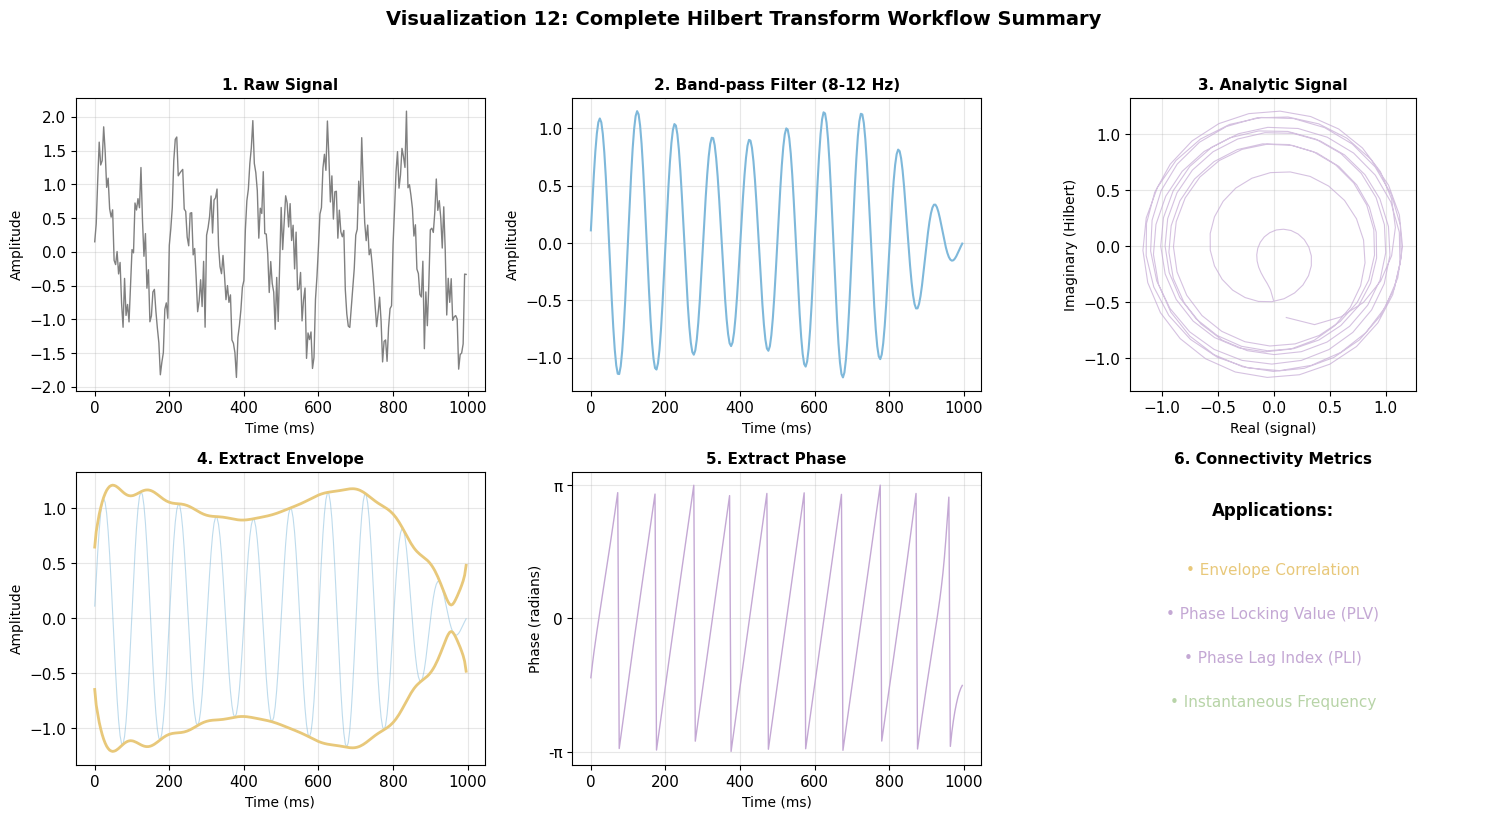

This workflow is the foundation for most phase-based connectivity metrics!
Next notebooks will build on these concepts.


In [15]:
# ============================================================================
# VISUALIZATION 12: Summary Diagram
# ============================================================================

# Create a summary visualization of the complete workflow
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Parameters
fs = 250
duration = 1.0
t = np.arange(0, duration, 1/fs)

# Create a mixed signal
np.random.seed(42)
raw_signal = (np.sin(2 * np.pi * 10 * t) + 
              0.5 * np.sin(2 * np.pi * 5 * t) + 
              0.3 * np.sin(2 * np.pi * 20 * t) +
              0.3 * np.random.randn(len(t)))

# Step 1: Raw signal
ax1 = axes[0, 0]
ax1.plot(t * 1000, raw_signal, color='gray', linewidth=1)
ax1.set_ylabel('Amplitude', fontsize=10)
ax1.set_title('1. Raw Signal', fontsize=11, fontweight='bold')
ax1.set_xlabel('Time (ms)', fontsize=10)
ax1.grid(True, alpha=0.3)

# Step 2: Band-pass filter
filtered = bandpass_filter(raw_signal, 8, 12, fs)
ax2 = axes[0, 1]
ax2.plot(t * 1000, filtered, color=PRIMARY_BLUE, linewidth=1.5)
ax2.set_ylabel('Amplitude', fontsize=10)
ax2.set_title('2. Band-pass Filter (8-12 Hz)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Time (ms)', fontsize=10)
ax2.grid(True, alpha=0.3)

# Step 3: Hilbert transform
analytic = hilbert(filtered)
ax3 = axes[0, 2]
ax3.plot(np.real(analytic), np.imag(analytic), color=ACCENT_PURPLE, linewidth=0.8, alpha=0.7)
ax3.set_xlabel('Real (signal)', fontsize=10)
ax3.set_ylabel('Imaginary (Hilbert)', fontsize=10)
ax3.set_title('3. Analytic Signal', fontsize=11, fontweight='bold')
ax3.set_aspect('equal')
ax3.grid(True, alpha=0.3)

# Step 4: Envelope
envelope = np.abs(analytic)
ax4 = axes[1, 0]
ax4.plot(t * 1000, filtered, color=PRIMARY_BLUE, linewidth=0.8, alpha=0.5)
ax4.plot(t * 1000, envelope, color=ACCENT_GOLD, linewidth=2)
ax4.plot(t * 1000, -envelope, color=ACCENT_GOLD, linewidth=2)
ax4.set_ylabel('Amplitude', fontsize=10)
ax4.set_xlabel('Time (ms)', fontsize=10)
ax4.set_title('4. Extract Envelope', fontsize=11, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Step 5: Phase
phase = np.angle(analytic)
ax5 = axes[1, 1]
ax5.plot(t * 1000, phase, color=ACCENT_PURPLE, linewidth=1)
ax5.set_ylabel('Phase (radians)', fontsize=10)
ax5.set_xlabel('Time (ms)', fontsize=10)
ax5.set_title('5. Extract Phase', fontsize=11, fontweight='bold')
ax5.set_yticks([-np.pi, 0, np.pi])
ax5.set_yticklabels(['-π', '0', 'π'])
ax5.grid(True, alpha=0.3)

# Step 6: Applications
ax6 = axes[1, 2]
ax6.text(0.5, 0.85, 'Applications:', fontsize=12, fontweight='bold', 
         ha='center', transform=ax6.transAxes)
ax6.text(0.5, 0.65, '• Envelope Correlation', fontsize=11, ha='center', 
         transform=ax6.transAxes, color=ACCENT_GOLD)
ax6.text(0.5, 0.50, '• Phase Locking Value (PLV)', fontsize=11, ha='center', 
         transform=ax6.transAxes, color=ACCENT_PURPLE)
ax6.text(0.5, 0.35, '• Phase Lag Index (PLI)', fontsize=11, ha='center', 
         transform=ax6.transAxes, color=ACCENT_PURPLE)
ax6.text(0.5, 0.20, '• Instantaneous Frequency', fontsize=11, ha='center', 
         transform=ax6.transAxes, color=PRIMARY_GREEN)
ax6.set_xlim(0, 1)
ax6.set_ylim(0, 1)
ax6.axis('off')
ax6.set_title('6. Connectivity Metrics', fontsize=11, fontweight='bold')

plt.suptitle('Visualization 12: Complete Hilbert Transform Workflow Summary', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("This workflow is the foundation for most phase-based connectivity metrics!")
print("Next notebooks will build on these concepts.")

---

## 15. Discussion Questions

1. **Narrowband Trade-off**: If you want to analyze theta (4-8 Hz) and alpha (8-13 Hz) together, what are your options? What are the trade-offs?

2. **Phase Reliability**: How would you determine if the instantaneous phase is reliable at a given time point? What threshold of amplitude would you use?

3. **Edge Effects in Practice**: In a hyperscanning experiment with 30-second epochs, how much data should you discard from each end when analyzing alpha band (10 Hz)?

4. **Wavelets vs Hilbert**: In what scenarios would you prefer wavelet-based phase extraction over Hilbert transform? Think about EEG event-related analyses.

5. **Interpretation**: Two hyperscanning participants show high PLV in alpha band. Does this mean they have the same alpha phase, or just that their phase difference is stable? What's the distinction?

---

## Next Steps

In the following notebooks, we will:
- **B02**: Explore phase in detail (unwrapping, circular statistics, phase relationships)
- **B03**: Deep dive into amplitude envelopes and their applications
- **B04**: Learn about wavelet-based time-frequency analysis

These concepts will then be applied to specific connectivity metrics in the **G series** (Phase-based metrics) and **H series** (Amplitude-based metrics).